In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import itertools
import sys
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, LogisticRegression
from xgboost import XGBClassifier
from xgboost import plot_tree
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
from sklearn.metrics import roc_curve, auc, make_scorer
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score
sns.set()

from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **1- Chargement des données**

In [0]:
data_url = "/content/drive/My Drive/datas/data_hypercube_with_litho.csv"

In [0]:
data = pd.read_csv(data_url)

In [0]:
data.head()

Unnamed: 0       WELL     DEPTH       GR  ...  RESMIC       SP   DEPTH_M  LITHO
0           0  10/1-A-10  2094.872  17.2000  ...     NaN -22.2857  2094.872      0
1           1  10/1-A-10  2095.024  18.7058  ...     NaN -20.0000  2095.024      0
2           2  10/1-A-10  2095.176  19.3092  ...     NaN -18.2857  2095.176      0
3           3  10/1-A-10  2095.328  19.1081  ...     NaN -16.5714  2095.328      0
4           4  10/1-A-10  2095.480  20.3536  ...     NaN -15.1429  2095.480      0

[5 rows x 17 columns]

In [0]:
data_geox = data.drop(columns=['Unnamed: 0', 'DEPTH'])

In [0]:
data_geox.head()

WELL       GR      CAL   DCOR  ...  RESMIC       SP   DEPTH_M  LITHO
0  10/1-A-10  17.2000  8.48605 -0.275  ...     NaN -22.2857  2094.872      0
1  10/1-A-10  18.7058  8.56870 -0.275  ...     NaN -20.0000  2095.024      0
2  10/1-A-10  19.3092  8.62140 -0.275  ...     NaN -18.2857  2095.176      0
3  10/1-A-10  19.1081  8.71425 -0.275  ...     NaN -16.5714  2095.328      0
4  10/1-A-10  20.3536  8.93990 -0.168  ...     NaN -15.1429  2095.480      0

[5 rows x 15 columns]

In [0]:
data_geox.shape

(472079, 15)

In [0]:
cols_x = ['GR','CAL','DCOR','DENS','DTC','PE','PHIN','RESD','RESM','RESS','RESMIC','SP']

In [0]:
data_geox = data_geox.loc[data_geox[cols_x].dropna(how='all').index].reset_index(drop=True)

In [0]:
data_geox.shape

(462225, 15)

In [0]:
data_geox.head()

WELL       GR      CAL   DCOR  ...  RESMIC       SP   DEPTH_M  LITHO
0  10/1-A-10  17.2000  8.48605 -0.275  ...     NaN -22.2857  2094.872      0
1  10/1-A-10  18.7058  8.56870 -0.275  ...     NaN -20.0000  2095.024      0
2  10/1-A-10  19.3092  8.62140 -0.275  ...     NaN -18.2857  2095.176      0
3  10/1-A-10  19.1081  8.71425 -0.275  ...     NaN -16.5714  2095.328      0
4  10/1-A-10  20.3536  8.93990 -0.168  ...     NaN -15.1429  2095.480      0

[5 rows x 15 columns]

In [0]:
pourc_nan = pd.DataFrame(data_geox.isnull().sum()/len(data_geox)*100)
pourc_nan = pourc_nan.T.drop(columns=['WELL', 'LITHO'])
pourc_nan.head()

GR       CAL       DCOR  ...     RESMIC         SP  DEPTH_M
0  1.297636  55.35248  60.708529  ...  89.293959  49.444102      0.0

[1 rows x 13 columns]

In [0]:
col = ['GR', 'CAL', 'DCOR', 'DENS', 'DTC', 'PHIN', 'RESD', 'RESM', 'SP' ]
X = data_geox[col].dropna()
y= data_geox['LITHO'].iloc[data_geox[col].dropna().index]

In [0]:
X.shape

(67443, 9)

In [0]:
y.shape

(67443,)

In [0]:
params_lasso  = np.arange(1,250, 0.1)
modele_lasso = LassoCV(alphas=params_lasso, cv=5).fit(X, y)

In [0]:
print('La valeur du paramètre optimal est: ' + str(round(modele_lasso.alpha_,3)))

La valeur du paramètre optimal est: 1.0


In [0]:
variables_lasso = np.where(modele_lasso.coef_ != 0)

In [0]:
val_lasso = variables_lasso[0]
print('Les variables sélectionnées par le Lasso sont: ' + str(val_lasso))

Les variables sélectionnées par le Lasso sont: [0 8]


In [0]:
count_val_lasso = variables_lasso[0].shape[0]
print('Le nombre de variable sélectionné par Lasso est: ' + str(count_val_lasso))

Le nombre de variable sélectionné par Lasso est: 2


In [0]:
col_lasso = ['GR', 'SP' ]
X_lasso = data_geox[col_lasso].dropna()
y_lasso = data_geox['LITHO'].iloc[data_geox[col_lasso].dropna().index]

In [0]:
X_lasso.shape

(231942, 2)

Autre méthode de sélection de features

In [0]:
# define feature selection
fs = SelectKBest(score_func=f_classif, k=5)
# apply feature selection
fs.fit(X,y)

SelectKBest(k=5, score_func=<function f_classif at 0x7fa875ca82f0>)

In [0]:
fs.get_support()

array([ True,  True, False, False, False,  True,  True,  True, False])

All combinations

In [0]:
stuff = ['GR', 'CAL', 'DCOR', 'DENS', 'DTC', 'PHIN', 'RESD', 'RESM', 'SP' ]
comb = []
for L in range(0, len(stuff)+1):
    for subset in itertools.combinations(stuff, L):
        comb.append(list(subset))

In [0]:
liste = []
for co in comb:
    if len(co) > 1 :
         liste.append(','.join(co))
            
    if len(co) == 1:
        liste.append(''.join(co))

In [0]:
len(liste)

# **2- LeaveOneGroupOut sur toutes les données**

In [0]:
from sklearn.model_selection import LeaveOneGroupOut

In [0]:
groups = data_geox.WELL.values
logo = LeaveOneGroupOut()
logo.get_n_splits(groups=groups)

61

In [0]:
X = data_geox[cols_x]
y = data_geox['LITHO']

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


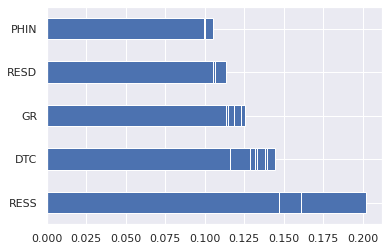

In [0]:
scores = []
precisions = []
count = 0
i = 0
index_test = {}
index_train = {}
for train_index, test_index in logo.split(X, y, groups=groups):
  #print(i)
  X_train, X_test = X.loc[train_index], X.loc[test_index]
  y_train, y_test = y.loc[train_index], y.loc[test_index]
  model = XGBClassifier(tree_method='gpu_hist', gpu_id=0)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  score = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  scores.append(score)
  precisions.append(precision)
  index_test[count] = test_index
  index_train[count] = train_index
  (pd.Series(model.feature_importances_, index=X_train.columns).nlargest(5).plot(kind='barh')) 
  i+=1
  count+=1
  #print(score)

In [0]:
well = data.WELL.unique().tolist()

Text(0, 0.5, 'Accuracy')

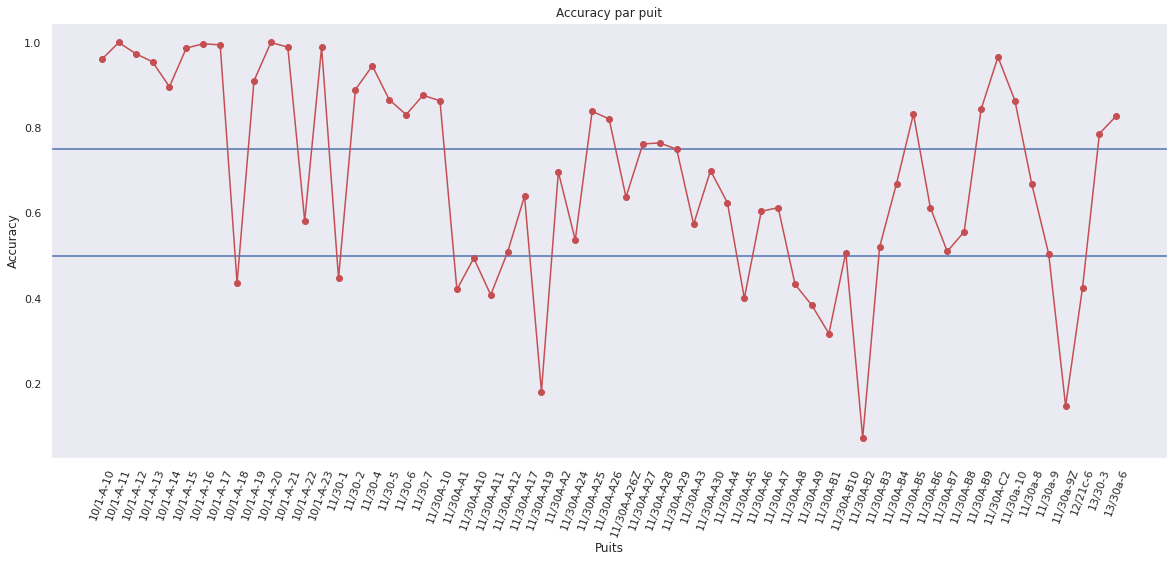

In [0]:
plt.figure(figsize=(20,8))
plt.axhline(y=0.5)
plt.axhline(y=0.75)
plt.grid()
plt.title('Accuracy par puit')
plt.plot(well, scores, 'ro-')
plt.xlabel('Puits')
plt.xticks(rotation=70)
plt.ylabel('Accuracy')

In [0]:
import statistics
statistics.mean(scores)

0.6851718118363864

Text(0, 0.5, 'Précisions')

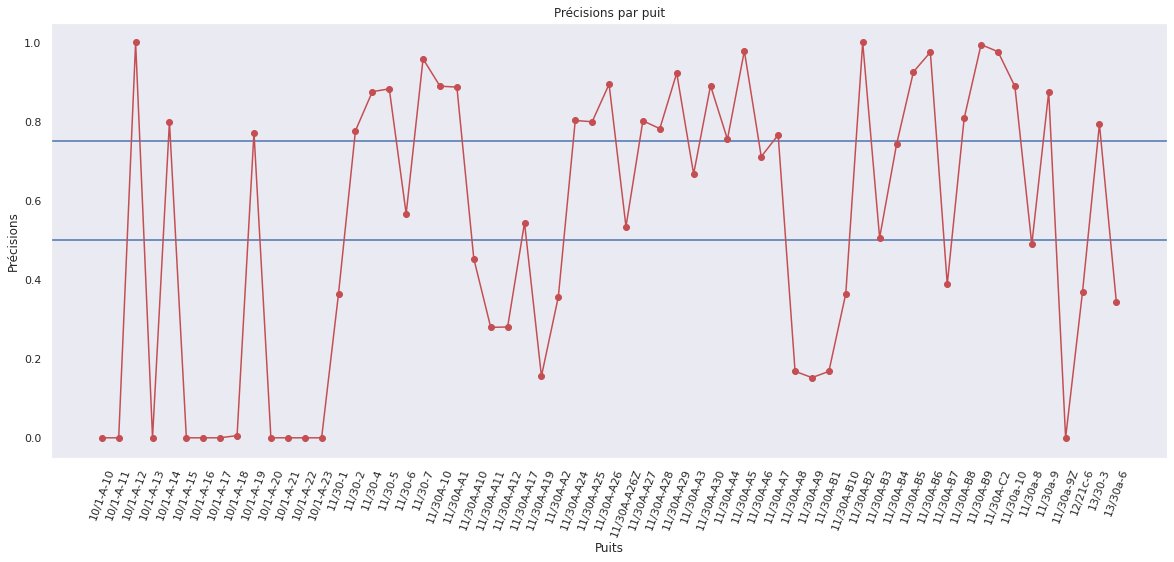

In [0]:
plt.figure(figsize=(20,8))
plt.axhline(y=0.5)
plt.axhline(y=0.75)
plt.grid()
plt.title('Précisions par puit')
plt.plot(well, precisions, 'ro-')
plt.xlabel('Puits')
plt.xticks(rotation=70)
plt.ylabel('Précisions')

In [0]:
statistics.mean(precisions)

0.5423401310746326

# 3-**Random Search CV**

In [0]:
xgb = XGBClassifier(tree_method='gpu_hist', gpu_id=0)

In [0]:
groups = data_geox.WELL.values
logo = LeaveOneGroupOut()
logo_cv = logo.split(data_geox[cols_x], data_geox['LITHO'], groups=groups)

In [0]:
scorer = make_scorer(precision_score, pos_label='1')

In [0]:
param_grid = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100,500,1000]}

In [0]:
rs_clf = RandomizedSearchCV(xgb, param_grid, n_iter=10, verbose=2, cv=5, n_jobs=1,
                            scoring='precision', refit=False, random_state=42)
rs_clf.fit(data_geox[cols_x], data_geox['LITHO'])

In [0]:
cvres = rs_clf.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(-mean_score, params)

-0.0 {'subsample': 0.9, 'silent': False, 'reg_lambda': 100.0, 'n_estimators': 100, 'min_child_weight': 5.0, 'max_depth': 6, 'learning_rate': 0, 'gamma': 0.5, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.9}
-0.5539927091084016 {'subsample': 0.8, 'silent': False, 'reg_lambda': 5.0, 'n_estimators': 500, 'min_child_weight': 0.5, 'max_depth': 6, 'learning_rate': 0.001, 'gamma': 0.5, 'colsample_bytree': 0.6, 'colsample_bylevel': 1.0}
-0.5193184249857027 {'subsample': 0.5, 'silent': False, 'reg_lambda': 0.1, 'n_estimators': 1000, 'min_child_weight': 10.0, 'max_depth': 20, 'learning_rate': 0.01, 'gamma': 1.0, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.9}
-0.49728588852050537 {'subsample': 0.9, 'silent': False, 'reg_lambda': 10.0, 'n_estimators': 1000, 'min_child_weight': 1.0, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 1.0, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.9}
-0.597424118185214 {'subsample': 1.0, 'silent': False, 'reg_lambda': 10.0, 'n_estimators': 500, 'min_child_wei

In [0]:
rs_clf.best_params_

{'colsample_bylevel': 0.7,
 'colsample_bytree': 1.0,
 'gamma': 0,
 'learning_rate': 3,
 'max_depth': 6,
 'min_child_weight': 1.0,
 'n_estimators': 500,
 'reg_lambda': 10.0,
 'silent': False,
 'subsample': 1.0}

In [0]:
resultDf = pd.DataFrame.from_dict(rs_clf.best_params_,orient='index').T

In [0]:
convert_dict = {'colsample_bylevel': float, 'colsample_bytree':float, 'gamma':float,'learning_rate':float
                , 'max_depth':int, 'min_child_weight':float, 'n_estimators':int, 'reg_lambda':float,
                'silent':bool, 'subsample':float} 
resultDf = resultDf.astype(convert_dict) 

In [0]:
resultDf.head()

subsample  silent  reg_lambda  ...  gamma  colsample_bytree  colsample_bylevel
0        1.0   False        10.0  ...    0.0               1.0                0.7

[1 rows x 10 columns]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

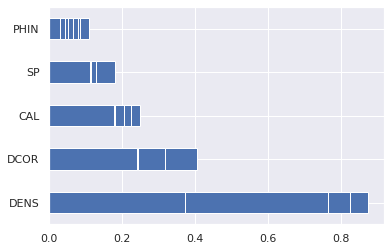

In [0]:
scores = []
precisions = []
count = 0
i = 0
index_test = {}
index_train = {}
for train_index, test_index in logo.split(X, y, groups=groups):
  #print(i)
  X_train, X_test = X.loc[train_index], X.loc[test_index]
  y_train, y_test = y.loc[train_index], y.loc[test_index]
  model = XGBClassifier(colsample_bylevel=resultDf.loc[0,'colsample_bylevel'], colsample_bytree=resultDf.loc[0,'colsample_bytree'],
                        gamma=resultDf.loc[0,'gamma'], learning_rate=resultDf.loc[0,'learning_rate'],
                        max_depth=resultDf.loc[0,'max_depth'], min_child_weight=resultDf.loc[0,'min_child_weight'],
                        n_estimators=resultDf.loc[0,'n_estimators'], reg_lambda=resultDf.loc[0,'reg_lambda'],
                        silent=resultDf.loc[0,'silent'], subsample=resultDf.loc[0,'subsample'], 
                        tree_method='gpu_hist', gpu_id=0)
  #model = XGBClassifier(learning_rate=0.1, max_depth=20, n_estimators=100,  silent=False, tree_method='gpu_hist', gpu_id=0)
  model.fit(X_train, y_train)
  #print(model.feature_importances_)
  y_pred = model.predict(X_test)
  score = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  scores.append(score)
  precisions.append(precision)
  index_test[count] = test_index
  index_train[count] = train_index
  (pd.Series(model.feature_importances_, index=X_train.columns).nlargest(5).plot(kind='barh')) 
  i+=1
  count+=1
  #print(score)

Text(0, 0.5, 'Accuracy')

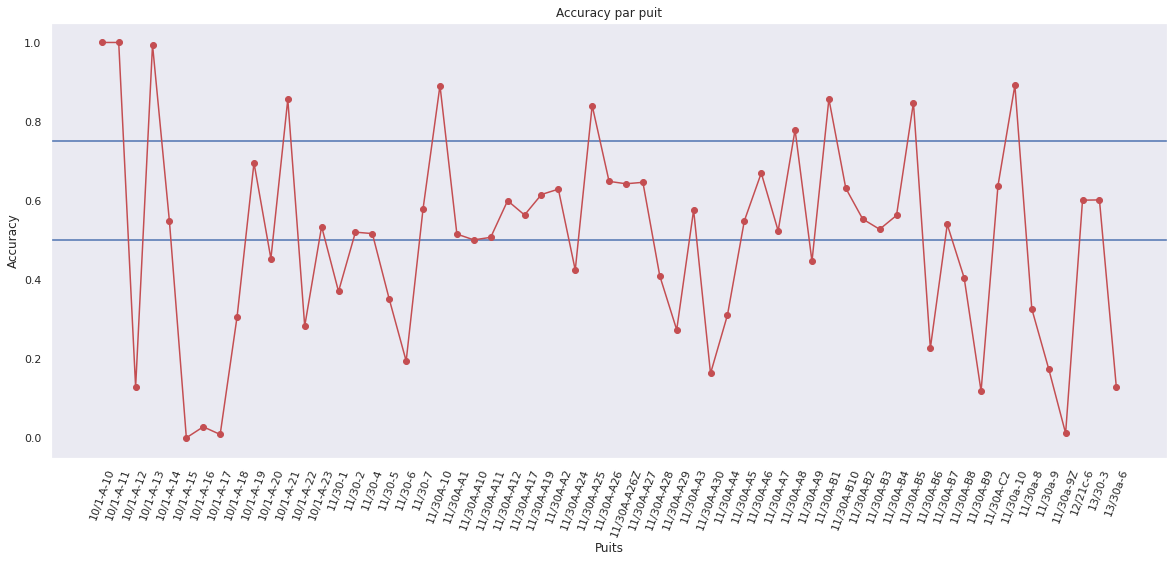

In [0]:
plt.figure(figsize=(20,8))
plt.grid()
plt.axhline(y=0.5)
plt.axhline(y=0.75)
plt.title('Accuracy par puit')
plt.plot(well, scores, 'ro-')
plt.xlabel('Puits')
plt.xticks(rotation=70)
plt.ylabel('Accuracy')

In [0]:
import statistics
statistics.mean(scores)

0.5037433688248258

Text(0, 0.5, 'Précisions')

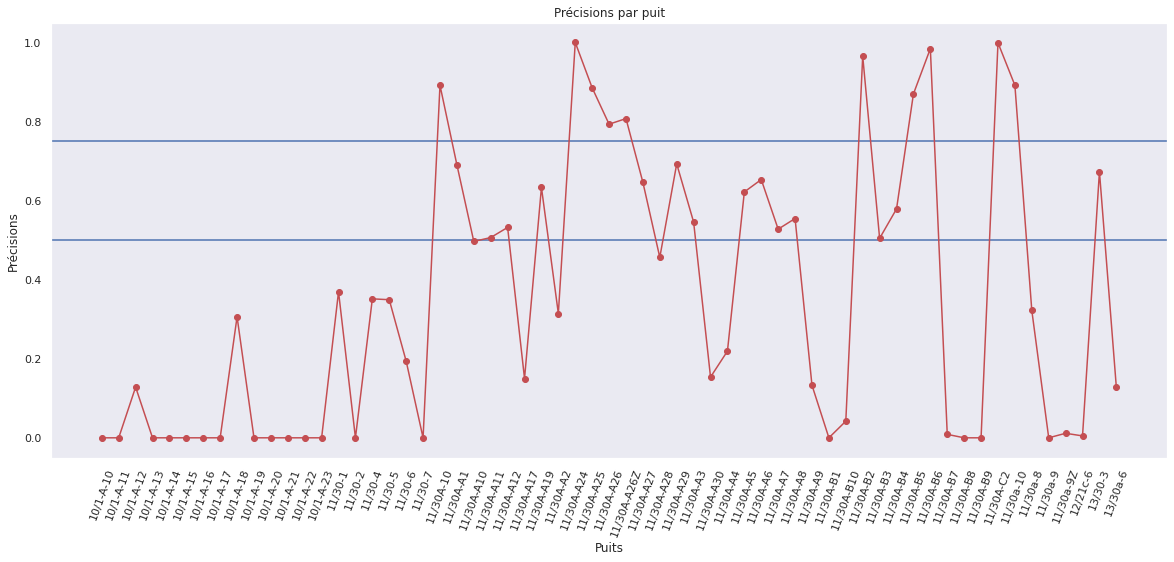

In [0]:
plt.figure(figsize=(20,8))
plt.grid()
plt.axhline(y=0.5)
plt.axhline(y=0.75)
plt.title('Précisions par puit')
plt.plot(well, precisions, 'ro-')
plt.xlabel('Puits')
plt.xticks(rotation=70)
plt.ylabel('Précisions')

In [0]:
import statistics
statistics.mean(precisions)

0.3539155375065104

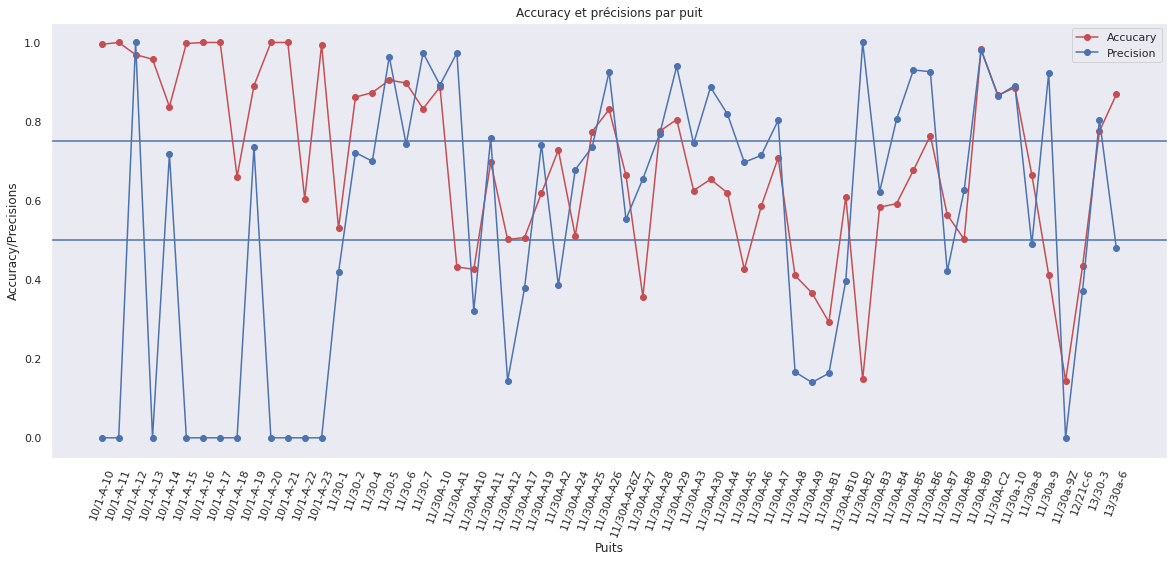

In [0]:
plt.figure(figsize=(20,8))
plt.grid()
plt.axhline(y=0.5)
plt.axhline(y=0.75)
plt.title('Accuracy et précisions par puit')
plt.plot(well, scores, 'ro-', label="Accucary")
plt.plot(well, precisions, 'bo-',label="Precision")
plt.xlabel('Puits')
plt.xticks(rotation=70)
plt.ylabel('Accuracy/Precisions')
plt.legend()

# 4-**Puits dont la précision est nulle**

In [0]:
index_null = np.where(np.array(precisions) == 0)

In [0]:
well = np.array(well)
well_null = []
precisions_null = []
for i in index_null[0]:
  well_null.append(well[i])
  precisions_null.append(precisions[i])

In [0]:
len(well_null)

12

In [0]:
well_3 = []
precisions_3 = []
for i in range(len(well_null)):
  if len(data_geox['LITHO'][data_geox['WELL'] == well_null[i]].unique()) == 2:
    well_3.append(well_null[i])
    precisions_3.append(precisions_null[i])

In [0]:
well_3

['10/1-A-18', '11/30a-9Z']

- On constate que les puits **10/1-A-18 et 11/30a-9Z** ont des précisions nulles alors que les **2 labels** sont présents dans les données. il faudra étudier de plus près ces puits.

- Pour les autres puits ayant des précisions nulles, c'est tout à fait normal car on remarque la présence d'une seule lithologie dans ces puits.

**Etude des 2 puits 10/1-A-18 et 11/30a-9Z**

Puit : 10/1-A-18
Pourcentage de valeurs Nan 
      GR  CAL   DCOR   DENS    DTC  ...      RESD      RESM   RESS  RESMIC        SP
0  100.0  0.0  100.0  100.0  100.0  ...  0.728863  0.728863  100.0   100.0  8.600583

[1 rows x 12 columns]
Index(['CAL', 'RESD', 'RESM', 'SP'], dtype='object')
[1 0]


Puit : 11/30a-9Z
Pourcentage de valeurs Nan 
    GR    CAL   DCOR   DENS  DTC  ...   RESD   RESM   RESS  RESMIC     SP
0  0.0  100.0  100.0  100.0  0.0  ...  100.0  100.0  100.0   100.0  100.0

[1 rows x 12 columns]
Index(['GR', 'DTC'], dtype='object')
[0 1]




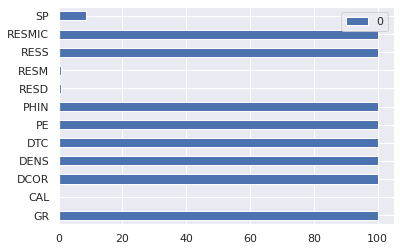

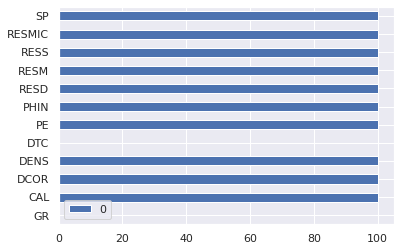

In [0]:
precisions_3_corr = []
for i in well_3:
  print("Puit : "+str(i))
  print("Pourcentage de valeurs Nan ")
  data = pd.DataFrame(data_geox[data_geox['WELL'] == i].isnull().sum()/len(data_geox[data_geox['WELL'] == i])*100)
  data = data.T.drop(columns=['WELL', 'LITHO', 'DEPTH_M'])
  print(data.head())
  (data.T).plot.barh()
  cols_x = data.columns[data.iloc[0] < 75]
  print(cols_x)
  print(data_geox['LITHO'][data_geox['WELL'] == i].unique())
  print('\n')
  X_train = data_geox[cols_x][data_geox['WELL'] != i]
  y_train = data_geox['LITHO'][data_geox['WELL'] != i]
  X_test = data_geox[cols_x][data_geox['WELL'] == i]
  y_test = data_geox['LITHO'][data_geox['WELL'] == i]
  model = XGBClassifier(colsample_bylevel=0.5, colsample_bytree=0.8, gamma=1.0,
   learning_rate=0.001, max_depth=10, min_child_weight=10.0, n_estimators=500, reg_lambda=5.0, silent=False, subsample=0.5, tree_method='gpu_hist', gpu_id=0)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  precision = precision_score(y_test, y_pred)
  precisions_3_corr.append(precision)

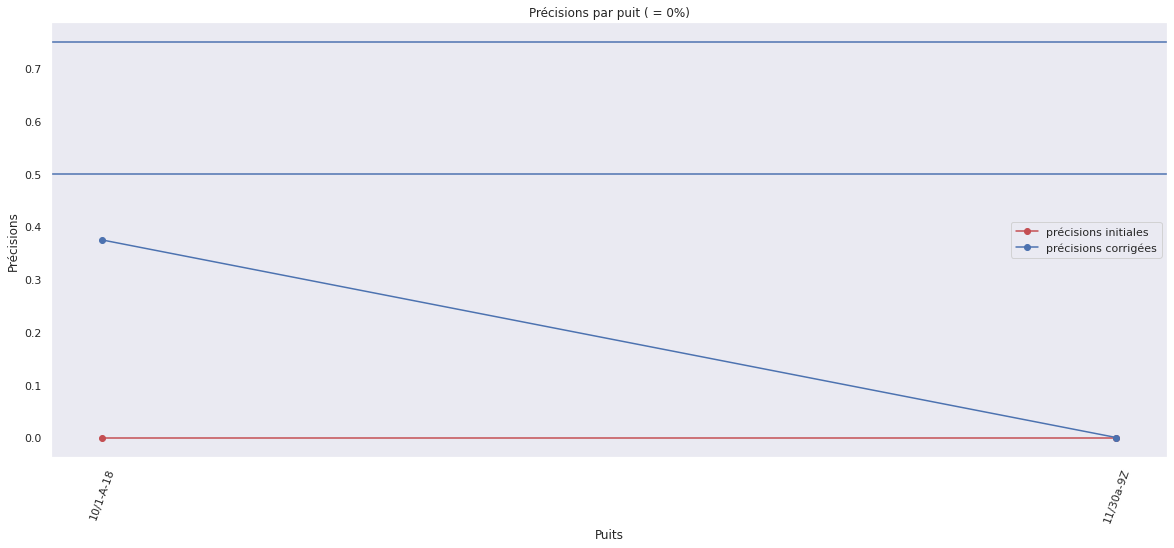

In [0]:
plt.figure(figsize=(20,8))
plt.grid()
plt.axhline(y=0.5)
plt.axhline(y=0.75)
plt.title('Précisions par puit ( = 0%)')
plt.plot(well_3, precisions_3, 'ro-', label='précisions initiales')
plt.plot(well_3, precisions_3_corr, 'bo-', label='précisions corrigées')
plt.xlabel('Puits')
plt.xticks(rotation=70)
plt.ylabel('Précisions')
plt.legend()

In [0]:
data = pd.DataFrame(data_geox[data_geox['WELL'] == '10/1-A-18'].isnull().sum()/len(data_geox[data_geox['WELL'] == '10/1-A-18'])*100)
data = data.T.drop(columns=['WELL', 'LITHO'])
data.head()

GR  CAL   DCOR   DENS    DTC  ...      RESM   RESS  RESMIC        SP  DEPTH_M
0  100.0  0.0  100.0  100.0  100.0  ...  0.728863  100.0   100.0  8.600583      0.0

[1 rows x 13 columns]

In [0]:
data = pd.DataFrame(data_geox[data_geox['WELL'] != '10/1-A-18'].isnull().sum()/len(data_geox[data_geox['WELL'] != '10/1-A-18'])*100)
data = data.T.drop(columns=['WELL', 'LITHO'])
data.head()

GR        CAL       DCOR  ...     RESMIC         SP  DEPTH_M
0  1.150932  55.434752  60.650129  ...  89.278046  49.504809      0.0

[1 rows x 13 columns]

- On constate en observant ce graphe, que seules les variables **GR et DTC** sont renseignées pour le puit **11/30a-9Z**. Ces variables ne sont pas suffisantes pour arriver à discriminer les 2 lithologies.

- pour le puit **10/1-A-18**, la précision a été améliorée de 30%. Cette faible amélioration s'explique sûrement par l'absence du log **GR** qui est une des variables les plus explicatives.

In [0]:
data_geox['LITHO'][(data_geox['WELL'] == '11/30a-9Z') & (data_geox['LITHO'] == 1)].count()

17

In [0]:
data_geox['LITHO'][data_geox['WELL'] == '11/30a-9Z'].shape

(1487,)

In [0]:
data_geox['LITHO'][(data_geox['WELL'] == '10/1-A-18') & (data_geox['LITHO'] == 1)].count()

210

In [0]:
data_geox['LITHO'][data_geox['WELL'] == '10/1-A-18'].shape

(686,)

# 5-**Etude des puits dont la précision est inférieure à 50% mais différente de 0%**

In [0]:
index_50 = np.where((np.array(precisions) < 0.5) & (np.array(precisions) != 0))

In [0]:
well_50 = []
precisions_50 = []
for i in index_50[0]:
  well_50.append(well[i])
  precisions_50.append(precisions[i])
print("Puits dont la précision est inférieure à 50% : "+ str(well_50))

Puits dont la précision est inférieure à 50% : ['11/30-1', '11/30A-A10', '11/30A-A12', '11/30A-A17', '11/30A-A2', '11/30A-A8', '11/30A-A9', '11/30A-B1', '11/30A-B10', '11/30A-B7', '11/30a-8', '12/21c-6', '13/30a-6']


In [0]:
len(well_50)

13

In [0]:
precisions_50_corr = []
for i in well_50:
  print("Puit : "+str(i))
  print("Pourcentage de valeurs Nan ")
  data = pd.DataFrame(data_geox[data_geox['WELL'] == i].isnull().sum()/len(data_geox[data_geox['WELL'] == i])*100)
  data = data.T.drop(columns=['WELL', 'LITHO', 'DEPTH_M'])
  print(data)
  cols_x = data.columns[data.iloc[0] < 75]
  print(cols_x)
  print(data_geox['LITHO'][data_geox['WELL'] == i].unique())
  print('\n')
  X_train = data_geox[cols_x][data_geox['WELL'] != i]
  y_train = data_geox['LITHO'][data_geox['WELL'] != i]
  X_test = data_geox[cols_x][data_geox['WELL'] == i]
  y_test = data_geox['LITHO'][data_geox['WELL'] == i]
  model = XGBClassifier(colsample_bylevel=0.5, colsample_bytree=0.8, gamma=1.0,
   learning_rate=0.001, max_depth=10, min_child_weight=10.0, n_estimators=500, reg_lambda=5.0, silent=False, subsample=0.5, tree_method='gpu_hist', gpu_id=0)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  precision = precision_score(y_test, y_pred)
  precisions_50_corr.append(precision)

Puit : 11/30-1
Pourcentage de valeurs Nan 
         GR        CAL       DCOR  ...       RESS  RESMIC         SP
0  0.354981  28.369413  28.631285  ...  24.470438   100.0  24.482076

[1 rows x 12 columns]
Index(['GR', 'CAL', 'DCOR', 'DENS', 'DTC', 'PHIN', 'RESS', 'SP'], dtype='object')
[1 0]


Puit : 11/30A-A10
Pourcentage de valeurs Nan 
         GR        CAL       DCOR  ...       RESS  RESMIC        SP
0  0.030819  72.956314  72.524848  ...  24.000308   100.0  24.40866

[1 rows x 12 columns]
Index(['GR', 'CAL', 'DCOR', 'DENS', 'DTC', 'PHIN', 'RESM', 'RESS', 'SP'], dtype='object')
[0 1]


Puit : 11/30A-A12
Pourcentage de valeurs Nan 
    GR        CAL       DCOR       DENS  ...       RESM   RESS     RESMIC        SP
0  0.0  90.800641  90.848679  90.800641  ...  62.177742  100.0  93.811049  0.048038

[1 rows x 12 columns]
Index(['GR', 'DTC', 'RESD', 'RESM', 'SP'], dtype='object')
[0 1]


Puit : 11/30A-A17
Pourcentage de valeurs Nan 
    GR        CAL       DCOR       DENS  ...       RE

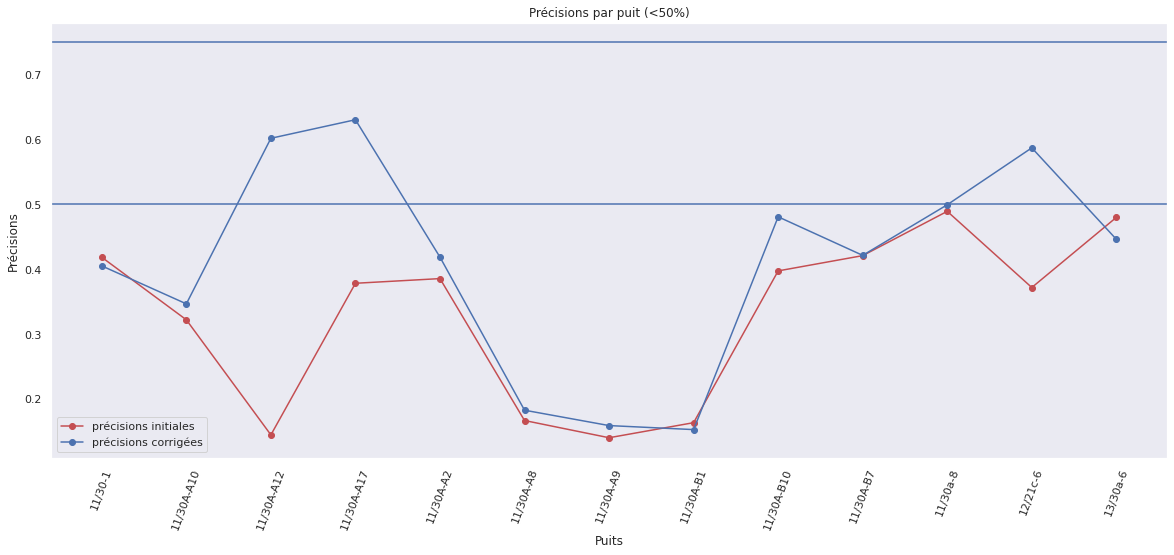

In [0]:
plt.figure(figsize=(20,8))
plt.grid()
plt.axhline(y=0.5)
plt.axhline(y=0.75)
plt.title('Précisions par puit (<50%)')
plt.plot(well_50, precisions_50, 'ro-', label='précisions initiales')
plt.plot(well_50, precisions_50_corr, 'bo-', label='précisions corrigées')
plt.xlabel('Puits')
plt.xticks(rotation=70)
plt.ylabel('Précisions')
plt.legend()

En prenant uniquement les logs, dont les valeurs nulles représentent moins de 75% des valeurs totales, on remarque que les précisions ont été améliorées seulement dans 3 puits: **11/30A-A12, 11/30A-A17, 12/21c-6**

# 6-**Etude des puits dont la précision est inférieure à 75% mais supérieure à 50%**

In [0]:
index_75 = np.where((np.array(precisions) > 0.5) & (np.array(precisions) < 0.75))

In [0]:
well_75 = []
precisions_75 = []
for i in index_75[0]:
  well_75.append(well[i])
  precisions_75.append(precisions[i])
print("Puits dont la précision est inférieure à 75% : "+ str(well_75))

Puits dont la précision est inférieure à 75% : ['10/1-A-14', '10/1-A-19', '11/30-2', '11/30-4', '11/30-6', '11/30A-A19', '11/30A-A24', '11/30A-A25', '11/30A-A26Z', '11/30A-A27', '11/30A-A3', '11/30A-A5', '11/30A-A6', '11/30A-B3', '11/30A-B8']


In [0]:
len(well_75)

15

In [0]:
precisions_75_corr = []
for i in well_75:
  print("Puit : "+str(i))
  print("Pourcentage de valeurs Nan ")
  data = pd.DataFrame(data_geox[data_geox['WELL'] == i].isnull().sum()/len(data_geox[data_geox['WELL'] == i])*100)
  data = data.T.drop(columns=['WELL', 'LITHO', 'DEPTH_M'])
  print(data.head())
  cols_x = data.columns[data.iloc[0] <= 75]
  print(cols_x)
  print(data_geox['LITHO'][data_geox['WELL'] == i].unique())
  print('\n')
  X_train = data_geox[cols_x][data_geox['WELL'] != i]
  y_train = data_geox['LITHO'][data_geox['WELL'] != i]
  X_test = data_geox[cols_x][data_geox['WELL'] == i]
  y_test = data_geox['LITHO'][data_geox['WELL'] == i]
  model = XGBClassifier(colsample_bylevel=0.5, colsample_bytree=0.8, gamma=1.0,
   learning_rate=0.001, max_depth=10, min_child_weight=10.0, n_estimators=500, reg_lambda=5.0, silent=False, subsample=0.5, tree_method='gpu_hist', gpu_id=0)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  precision = precision_score(y_test, y_pred)
  precisions_75_corr.append(precision)

Puit : 10/1-A-14
Pourcentage de valeurs Nan 
         GR  CAL      DCOR  DENS  ...       RESM   RESS  RESMIC         SP
0  0.932091  0.0  1.464714   0.0  ...  55.792277  100.0   100.0  55.792277

[1 rows x 12 columns]
Index(['GR', 'CAL', 'DCOR', 'DENS', 'DTC', 'PHIN', 'RESD', 'RESM', 'SP'], dtype='object')
[1 0]


Puit : 10/1-A-19
Pourcentage de valeurs Nan 
         GR        CAL       DCOR  ...   RESS  RESMIC         SP
0  26.88588  68.762089  70.212766  ...  100.0   100.0  38.491296

[1 rows x 12 columns]
Index(['GR', 'CAL', 'DCOR', 'DENS', 'DTC', 'PHIN', 'RESD', 'RESM', 'SP'], dtype='object')
[1 0]


Puit : 11/30-2
Pourcentage de valeurs Nan 
         GR        CAL     DCOR  ...       RESS  RESMIC         SP
0  0.290143  56.814538  81.8279  ...  25.456211   100.0  25.479117

[1 rows x 12 columns]
Index(['GR', 'CAL', 'DTC', 'RESS', 'SP'], dtype='object')
[1 0]


Puit : 11/30-4
Pourcentage de valeurs Nan 
         GR        CAL       DCOR  ...       RESS  RESMIC         SP
0  0.22704

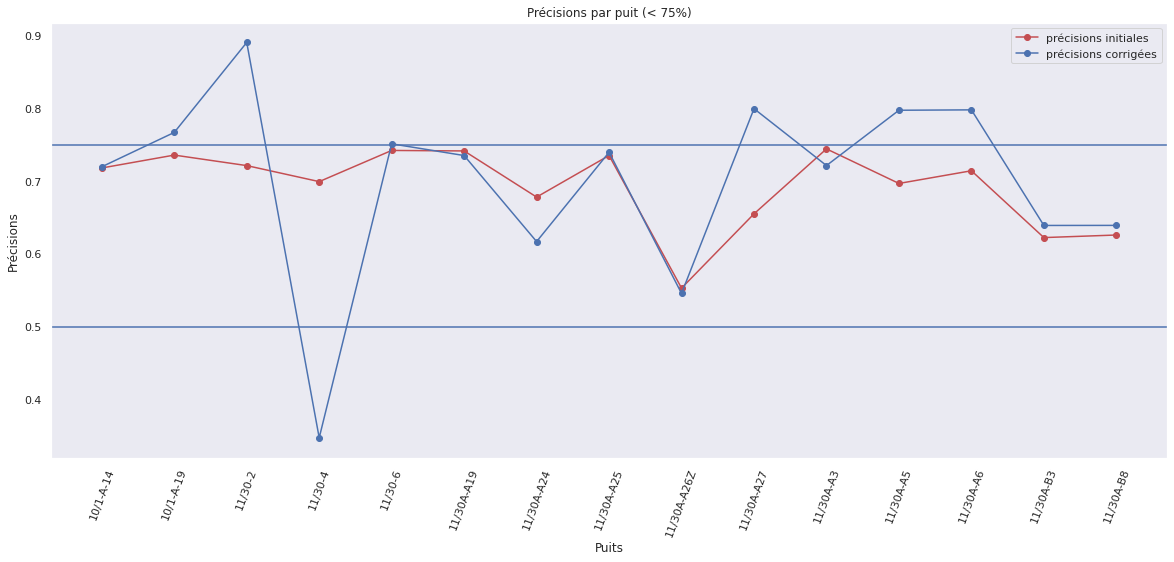

In [0]:
plt.figure(figsize=(20,8))
plt.grid()
plt.axhline(y=0.5)
plt.axhline(y=0.75)
plt.title('Précisions par puit (< 75%)')
plt.plot(well_75, precisions_75, 'ro-', label='précisions initiales')
plt.plot(well_75, precisions_75_corr, 'bo-', label='précisions corrigées')
plt.xlabel('Puits')
plt.xticks(rotation=70)
plt.ylabel('Précisions')
plt.legend()

En prenant uniquement les logs, dont les valeurs nulles représentent moins de 75% des valeurs totales, on remarque que les précisions ont été condidérablement améliorées dans 3 puits: **11/30-2, 11/30A-A27**

#8-**Etude des puits dont la précision est supérieure à 75%**

In [0]:
index_100 = np.where(np.array(precisions) > 0.75)

In [0]:
well_100 = []
precisions_100 = []
for i in index_100[0]:
  well_100.append(well[i])
  precisions_100.append(precisions[i])
print("Puits dont la précision est supérieure à 75% : "+ str(well_100))

Puits dont la précision est supérieure à 75% : ['10/1-A-12', '11/30-5', '11/30-7', '11/30A-10', '11/30A-A1', '11/30A-A11', '11/30A-A26', '11/30A-A28', '11/30A-A29', '11/30A-A30', '11/30A-A4', '11/30A-A7', '11/30A-B2', '11/30A-B4', '11/30A-B5', '11/30A-B6', '11/30A-B9', '11/30A-C2', '11/30a-10', '11/30a-9', '13/30-3']


In [0]:
len(well_100)

21

In [0]:
precisions_100_corr = []
for i in well_100:
  print("Puit : "+str(i))
  print("Pourcentage de valeurs Nan ")
  data = pd.DataFrame(data_geox[data_geox['WELL'] == i].isnull().sum()/len(data_geox[data_geox['WELL'] == i])*100)
  data = data.T.drop(columns=['WELL', 'LITHO', 'DEPTH_M'])
  print(data.head())
  cols_x = data.columns[data.iloc[0] <= 75]
  print(cols_x)
  print(data_geox['LITHO'][data_geox['WELL'] == i].unique())
  print('\n')
  X_train = data_geox[cols_x][data_geox['WELL'] != i]
  y_train = data_geox['LITHO'][data_geox['WELL'] != i]
  X_test = data_geox[cols_x][data_geox['WELL'] == i]
  y_test = data_geox['LITHO'][data_geox['WELL'] == i]
  model = XGBClassifier(colsample_bylevel=0.5, colsample_bytree=0.8, gamma=1.0,
   learning_rate=0.001, max_depth=10, min_child_weight=10.0, n_estimators=500, reg_lambda=5.0, silent=False, subsample=0.5, tree_method='gpu_hist', gpu_id=0)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  precision = precision_score(y_test, y_pred)
  precisions_100_corr.append(precision)

Puit : 10/1-A-12
Pourcentage de valeurs Nan 
    GR  CAL      DCOR  DENS    DTC     PE  PHIN  RESD  RESM   RESS  RESMIC   SP
0  0.0  0.0  2.612827   0.0  100.0  100.0   0.0   0.0   0.0  100.0   100.0  0.0
Index(['GR', 'CAL', 'DCOR', 'DENS', 'PHIN', 'RESD', 'RESM', 'SP'], dtype='object')
[1 0]


Puit : 11/30-5
Pourcentage de valeurs Nan 
         GR        CAL       DCOR  ...       RESS  RESMIC         SP
0  0.317375  86.109798  85.448038  ...  27.793909   100.0  27.766899

[1 rows x 12 columns]
Index(['GR', 'DTC', 'RESS', 'SP'], dtype='object')
[1 0]


Puit : 11/30-7
Pourcentage de valeurs Nan 
         GR       CAL      DCOR  ...      RESS  RESMIC        SP
0  0.447116  88.40431  88.39698  ...  0.102617   100.0  1.158103

[1 rows x 12 columns]
Index(['GR', 'DTC', 'RESS', 'SP'], dtype='object')
[1 0]


Puit : 11/30A-10
Pourcentage de valeurs Nan 
         GR       CAL      DCOR      DENS  ...       RESM       RESS  RESMIC     SP
0  0.122654  0.729793  1.612903  1.208144  ...  97.313872

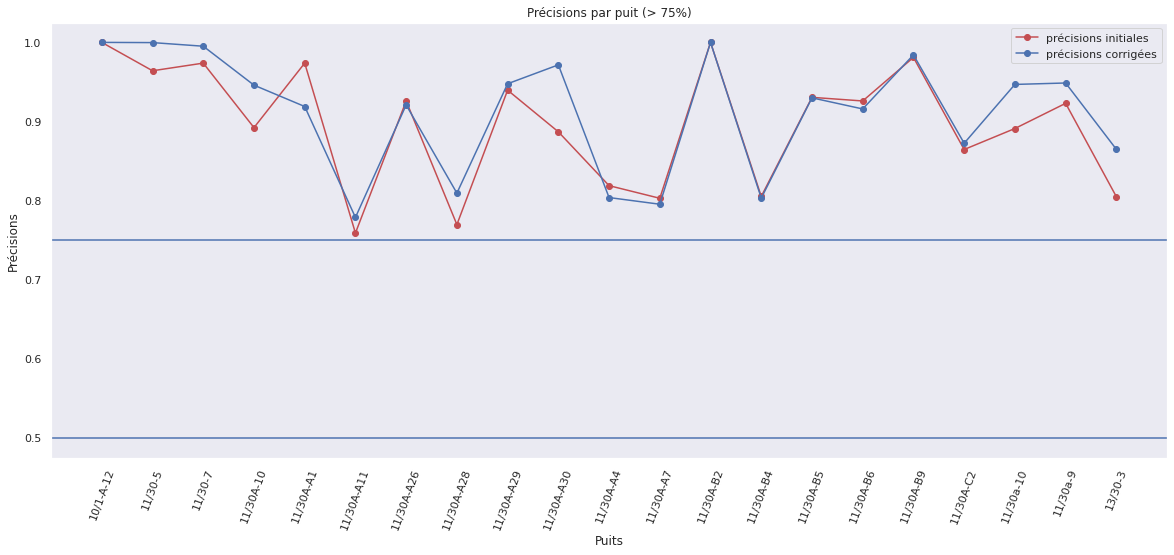

In [0]:
plt.figure(figsize=(20,8))
plt.grid()
plt.axhline(y=0.5)
plt.axhline(y=0.75)
plt.title('Précisions par puit (> 75%)')
plt.plot(well_100, precisions_100, 'ro-', label='précisions initiales')
plt.plot(well_100, precisions_100_corr, 'bo-', label='précisions corrigées')
plt.xlabel('Puits')
plt.xticks(rotation=70)
plt.ylabel('Précisions')
plt.legend()

Globalement, pour les puits dont la précision **est supérieure à 75%**, on ne note pas d améliorations considérables de la précision

# 9-Extrapolation du puit 11/30a-8

In [0]:
data_ext = pd.DataFrame(data_geox[data_geox['WELL'] == '11/30a-8'].isnull().sum()/len(data_geox[data_geox['WELL'] == '11/30a-8'])*100)

In [0]:
data_ext = data_ext.T

In [0]:
data_ext.head()

WELL        GR        CAL       DCOR  ...       RESS  RESMIC         SP  LITHO
0   0.0  0.515606  42.265915  78.729548  ...  11.487694   100.0  11.281452    0.0

[1 rows x 14 columns]

In [0]:
data = pd.read_csv(data_url)

In [0]:
data_tri = data[data['WELL'] == '11/30a-8'].sort_values(by = 'DEPTH_M', ascending = True).drop(columns=['Unnamed: 0', 'DEPTH']).reset_index()

In [0]:
data_tri.tail()

index      WELL  GR  CAL  DCOR  ...  RESS  RESMIC       SP    DEPTH_M  LITHO
14754  404564  11/30a-8 NaN  NaN   NaN  ...   NaN     NaN -42.7562  2525.4204      0
14755  404565  11/30a-8 NaN  NaN   NaN  ...   NaN     NaN -44.6469  2525.5728      0
14756  404566  11/30a-8 NaN  NaN   NaN  ...   NaN     NaN -43.8031  2525.7252      0
14757  404567  11/30a-8 NaN  NaN   NaN  ...   NaN     NaN -48.5219  2525.8776      0
14758  404568  11/30a-8 NaN  NaN   NaN  ...   NaN     NaN -48.9437  2526.0300      0

[5 rows x 16 columns]

In [0]:
data_tri.shape

(14759, 16)

In [0]:
data_tri = data_tri.loc[data_tri[cols_x].dropna(how='all').index]

In [0]:
data_tri.shape

(14540, 16)

In [0]:
from sklearn.impute import KNNImputer

In [0]:
imputer = KNNImputer(n_neighbors=5)

In [0]:
data_tri['RESS'] = imputer.fit_transform(data_tri[['RESS']])
data_tri['GR'] = imputer.fit_transform(data_tri[['GR']])
data_tri['SP'] = imputer.fit_transform(data_tri[['SP']])
data_tri['DTC'] = imputer.fit_transform(data_tri[['DTC']])

In [0]:
data_tri.tail()

index      WELL         GR     CAL  ...  RESMIC       SP    DEPTH_M  LITHO
14748  404558  11/30a-8  51.999553  7.2138  ...     NaN -43.8500  2524.5060      0
14749  404559  11/30a-8  51.999553  6.9500  ...     NaN -39.0844  2524.6584      0
14750  404560  11/30a-8  51.999553  6.5520  ...     NaN -42.7250  2524.8108      0
14751  404561  11/30a-8  51.999553  6.2192  ...     NaN -45.7094  2524.9632      0
14752  404562  11/30a-8  51.999553  6.0493  ...     NaN -44.9125  2525.1156      0

[5 rows x 16 columns]

In [0]:
X_train = data_geox[cols_x][data_geox['WELL'] !='11/30a-8' ]
y_train = data_geox['LITHO'][data_geox['WELL'] != '11/30a-8']

X_test = data_tri[cols_x]
y_test = data_tri['LITHO']

model = XGBClassifier(colsample_bylevel=0.5, colsample_bytree=0.8, gamma=1.0,
  learning_rate=0.001, max_depth=10, min_child_weight=10.0, n_estimators=500, reg_lambda=5.0, silent=False, subsample=0.5, tree_method='gpu_hist', gpu_id=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
precision = precision_score(y_test, y_pred)

In [0]:
precision

0.43465074400530757

**L'imputation des valeurs n'améliore pas la précision.**

# 10- **Modélisation en prenant les puits Frigg comme jeu de données Test**

In [0]:
def tuning_params(X_train, y_train, grille=1):

  xgb = XGBClassifier(tree_method='gpu_hist', gpu_id=0)

  if grille == 1:
    param_grid = {
          'silent': [False],
          'max_depth': [6, 10, 15, 20],
          'learning_rate': [0.001,0.005, 0.01, 0.04, 0.1, 0.2, 0.3, 0.6,1.0],
          'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
          'gamma': [0, 0.25, 0.5, 1.0],
          'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
          'n_estimators': [100,500,1000]}
  else:
     param_grid = {
          'silent': [False],
          'max_depth': [6],
          'learning_rate': [0.001,0.005, 0.01, 0.04, 0.1, 0.2, 0.3, 0.6,1.0],
          'subsample': [1.0],
          'colsample_bytree': [1.0],
          'colsample_bylevel': [1.0],
          'min_child_weight': [1.0],
          'gamma': [0],
          'reg_lambda': [1.0],
          'n_estimators': [100]}


  rs_clf = RandomizedSearchCV(xgb, param_grid, n_iter=30, cv=5, n_jobs=1,
                            scoring='precision', refit=True, random_state=0)
  rs_clf.fit(X_train, y_train)

  resultDf = pd.DataFrame.from_dict(rs_clf.best_params_,orient='index').T

  convert_dict = {'colsample_bylevel': float, 'colsample_bytree':float, 'gamma':float,'learning_rate':float
                , 'max_depth':int, 'min_child_weight':float, 'n_estimators':int, 'reg_lambda':float,
                'silent':bool, 'subsample':float} 

  resultDf = resultDf.astype(convert_dict) 
  return resultDf


In [0]:
def xgboost_class(X_train, y_train, X_test, y_test, params):
  model = XGBClassifier(colsample_bylevel=params.loc[0,'colsample_bylevel'], colsample_bytree=params.loc[0,'colsample_bytree'],
                        gamma=params.loc[0,'gamma'], learning_rate=params.loc[0,'learning_rate'],
                        max_depth=params.loc[0,'max_depth'], min_child_weight=params.loc[0,'min_child_weight'],
                        n_estimators=params.loc[0,'n_estimators'], reg_lambda=params.loc[0,'reg_lambda'],
                        silent=params.loc[0,'silent'], subsample=params.loc[0,'subsample'], 
                        tree_method='gpu_hist', gpu_id=0)
  
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  score = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  proba = model.predict_proba(X_test)
  return score, precision, proba

In [0]:
def roc_courbe(fpr,tpr,auc):
  plt.figure()
  plt.plot(fpr, tpr, label='AUC %.2f' % auc)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.01])
  plt.ylim([0.0, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc='lower right')
  plt.legend(loc='lower right')
  plt.show()

In [0]:
def roc_courbe2(fpr1,tpr1,auc1,fpr2,tpr2,auc2):
  plt.figure()
  plt.plot(fpr1, tpr1, label='AUC model full %.2f' % auc1)
  plt.plot(fpr2, tpr2, label='AUC model clean %.2f' % auc2)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.01])
  plt.ylim([0.0, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc='lower right')
  plt.legend(loc='lower right')
  plt.show()

In [0]:
#well_frigg = ['10/1-A-23', '10/1-A-19', '10/1-A-11', '10/1-A-20', '10/1-A-15', '10/1-A-10', '10/1-A-22', '10/1-A-18', '10/1-A-13','10/1-A-21', '10/1-A-12', '10/1-A-17', '10/1-A-14', '10/1-A-16']
well_frigg = ['10/1-A-19', '10/1-A-18', '10/1-A-12', '10/1-A-14']
well_others = [ '10/1-A-19', '10/1-A-18', '10/1-A-12', '10/1-A-14','11/30A-A1', '11/30A-A28','13/30-3', '11/30-2','11/30A-A26Z','11/30A-A27']

In [0]:
data_geox_frig = data_geox[data_geox['WELL'].isin(well_frigg)]
data_geox_not_frig = data_geox[data_geox['WELL'].isin(well_others) == False ]

In [0]:
data_geox_frig_ext = pd.DataFrame(data_geox_frig.isnull().sum()/len(data_geox_frig)*100)
data_geox_not_frig_ext = pd.DataFrame(data_geox_not_frig.isnull().sum()/len(data_geox_not_frig)*100)

In [0]:
data_geox_frig_ext.T.head()

WELL        GR        CAL       DCOR  ...  RESMIC         SP  DEPTH_M  LITHO
0   0.0  33.57538  24.585062  49.585062  ...   100.0  30.290456      0.0    0.0

[1 rows x 15 columns]

In [0]:
data_geox_not_frig_ext.T.head()

WELL        GR        CAL       DCOR  ...     RESMIC         SP  DEPTH_M  LITHO
0   0.0  0.924485  57.066118  62.782431  ...  88.569064  48.437353      0.0    0.0

[1 rows x 15 columns]

Text(0.5, 1.0, 'Histogramme de distribution des GR par label')

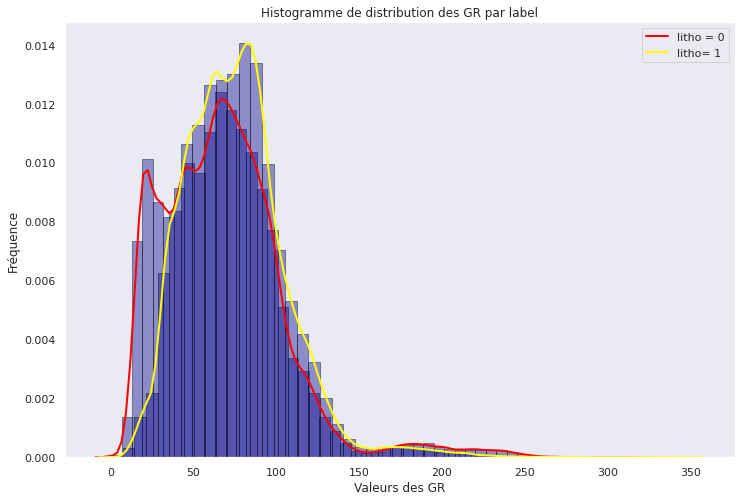

In [0]:
plt.figure(figsize=(12,8))
sns.distplot(data_geox_not_frig['GR'].dropna()[data_geox_not_frig['LITHO'] == 0], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(data_geox_not_frig['GR'].dropna()[data_geox_not_frig['LITHO'] == 1], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des GR')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des GR par label')

Text(0.5, 1.0, 'Histogramme de distribution des GR par label')

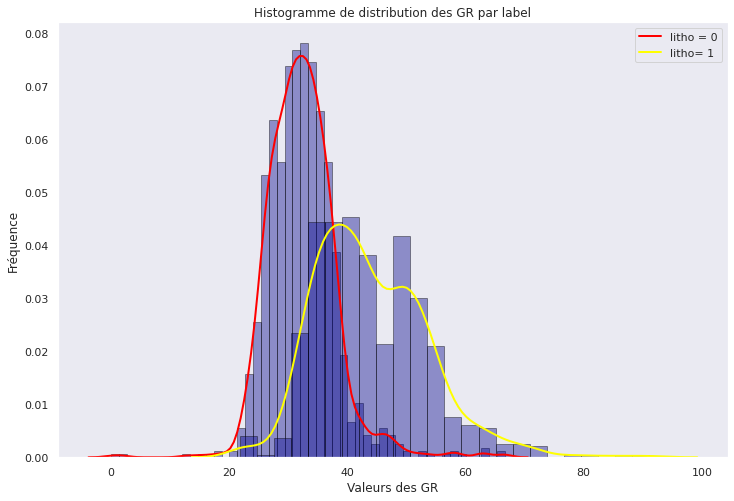

In [0]:
plt.figure(figsize=(12,8))
sns.distplot(data_geox_frig['GR'].dropna()[data_geox_frig['LITHO'] == 0], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'litho = 0'})
sns.distplot(data_geox_frig['GR'].dropna()[data_geox_frig['LITHO'] == 1], color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},kde=True, kde_kws = {'color': 'yellow', 'lw': 2, 'label':'litho= 1'})
plt.grid()
plt.xlabel('Valeurs des GR')
plt.ylabel('Fréquence')
plt.title('Histogramme de distribution des GR par label')

In [0]:
data_geox_frig.shape

(2892, 15)

In [0]:
data_geox_not_frig.shape

(414393, 15)

In [0]:
cols_x = ['GR','DTC','DENS','PHIN']
cols_x_2 = ['GR','DTC','DENS','DCOR','PHIN']

In [0]:
X_train_not_frig = data_geox_not_frig[cols_x]
y_train_not_frig = data_geox_not_frig['LITHO']

In [0]:
X_train_not_frig_2 = data_geox_not_frig[cols_x_2]

In [0]:
X_train_not_frig_clean = data_geox_not_frig[cols_x].dropna()
y_train_not_frig_clean = data_geox_not_frig['LITHO'].loc[data_geox_not_frig[cols_x].dropna().index]

In [0]:
print(X_train_not_frig_clean.shape)

(135208, 4)


In [0]:
X_train_not_frig_clean_2 = data_geox_not_frig[cols_x_2].dropna()
y_train_not_frig_clean_2 = data_geox_not_frig['LITHO'].loc[data_geox_not_frig[cols_x_2].dropna().index]

In [0]:
print(X_train_not_frig_clean_2.shape)

(129779, 5)


In [0]:
params_train_not_frig = tuning_params(X_train_not_frig, y_train_not_frig)

In [0]:
params_train_not_frig.head()

subsample  silent  reg_lambda  ...  gamma  colsample_bytree  colsample_bylevel
0        0.8   False       100.0  ...   0.25               0.9                0.8

[1 rows x 10 columns]

In [0]:
params_train_not_frig_2 = tuning_params(X_train_not_frig_2, y_train_not_frig)

In [0]:
params_train_not_frig_2.head()

subsample  silent  reg_lambda  ...  gamma  colsample_bytree  colsample_bylevel
0        0.6   False         5.0  ...    0.5               0.9                0.4

[1 rows x 10 columns]

In [0]:
params_train_not_frig_clean = tuning_params(X_train_not_frig_clean, y_train_not_frig_clean)

In [0]:
params_train_not_frig_clean.head()

subsample  silent  reg_lambda  ...  gamma  colsample_bytree  colsample_bylevel
0        0.7   False        10.0  ...    0.0               0.8                0.4

[1 rows x 10 columns]

In [0]:
params_train_not_frig_clean_2 = tuning_params(X_train_not_frig_clean_2, y_train_not_frig_clean_2)

In [0]:
params_train_not_frig_clean_2.head()

subsample  silent  reg_lambda  ...  gamma  colsample_bytree  colsample_bylevel
0        0.6   False         1.0  ...    0.0               0.7                0.7

[1 rows x 10 columns]

In [0]:
#X_test_frig = scaler_2.transform(data_geox_frig[cols_x])
X_test_frig = data_geox_frig[cols_x]
y_test_frig = data_geox_frig['LITHO']

In [0]:
X_test_frig_clean = data_geox_frig[cols_x].dropna()
y_test_frig_clean = data_geox_frig['LITHO'].loc[data_geox_frig[cols_x].dropna().index]

In [0]:
print(X_test_frig_clean.shape)

(743, 4)


In [0]:
X_test_frig_2 = data_geox_frig[cols_x_2]

In [0]:
X_test_frig_clean_2 = data_geox_frig[cols_x_2].dropna()
y_test_frig_clean_2 = data_geox_frig['LITHO'].loc[data_geox_frig[cols_x_2].dropna().index]

In [0]:
print(X_test_frig_clean_2.shape)

(734, 5)


In [0]:
np.where(y_test_frig_clean_2==1)[0].shape

(311,)

In [0]:
X_test_frig_clean_2.head(10)

GR   DTC    DENS   DCOR    PHIN
1503  31.6  38.8  2.3903 -0.224  0.5952
1504  31.6  38.8  2.3903 -0.224  0.5952
1505  31.6  38.8  2.3903 -0.224  0.5952
1506  31.6  38.8  2.3903 -0.224  0.5952
1507  31.6  38.8  2.3903 -0.224  0.5952
1508  31.6  38.8  2.3903 -0.224  0.5952
1509  32.6  38.8  2.3903 -0.224  0.5956
1510  34.2  38.8  2.4039 -0.224  0.6016
1511  32.6  38.8  2.4194 -0.224  0.5940
1512  30.8  38.8  2.4290 -0.224  0.6080

In [0]:
np.where(y_test_frig_clean_2==0)[0].shape

(423,)

In [0]:
data_geox_frig['LITHO'][(data_geox_frig['WELL'] == '10/1-A-18') & (data_geox_frig['LITHO'] == 1)].count()

210

In [0]:
comb = ["GR","GR,DTC", "All-logs", "GR,DTC,RESD,RESM","GR,DTC,RESD,RESM,SP", "GR,DTC,RESS,SP","GR,DTC,SP","GR,PHIN","GR,DTC,PHIN,SP", 
           "GR,DCOR,PHIN","GR,DENS,PHIN", "GR,DTC,PHIN", "GR,DCOR,DENS,PHIN", "GR,DTC,DENS,PHIN", "GR,DCOR,DTC,PHIN",
           "GR,DTC,DCOR,DENS,PHIN"]

In [0]:
prec_comb = []
for col in comb:
  print(col.split(','))
  if col == 'All-logs':
    X_train = data_geox_not_frig.drop(columns=['WELL', 'DEPTH_M', 'LITHO' ])
    y_train = data_geox_not_frig['LITHO']
    X_test = data_geox_frig.drop(columns=['WELL', 'DEPTH_M', 'LITHO' ])
    y_test = data_geox_frig['LITHO']
  else:
    X_train = data_geox_not_frig[col.split(',')]
    y_train = data_geox_not_frig['LITHO']
    X_test = data_geox_frig[col.split(',')]
    y_test = data_geox_frig['LITHO']
  score, precision = xgboost_class(X_train, y_train,X_test, y_test)
  prec_comb.append(precision)

['GR']
['GR', 'DTC']
['All-logs']
['GR', 'DTC', 'RESD', 'RESM']
['GR', 'DTC', 'RESD', 'RESM', 'SP']
['GR', 'DTC', 'RESS', 'SP']
['GR', 'DTC', 'SP']
['GR', 'PHIN']
['GR', 'DTC', 'PHIN', 'SP']
['GR', 'DCOR', 'PHIN']
['GR', 'DENS', 'PHIN']
['GR', 'DTC', 'PHIN']
['GR', 'DCOR', 'DENS', 'PHIN']
['GR', 'DTC', 'DENS', 'PHIN']
['GR', 'DCOR', 'DTC', 'PHIN']
['GR', 'DTC', 'DCOR', 'DENS', 'PHIN']


In [0]:
print(prec_comb)

[0.8452062131762186, 0.7634042553191489, 0.8875441250630358, 0.7375651350071056, 0.8745019920318725, 0.8558558558558559, 0.869281045751634, 0.8343088698784331, 0.8903638151425762, 0.8884559181685339, 0.884992987377279, 0.8893518518518518, 0.8670360110803325, 0.8853881278538813, 0.8715596330275229, 0.8711409395973154]


Text(0.5, 1.0, 'Précisions en fonction des logs (Test sur champ FRIGG)')

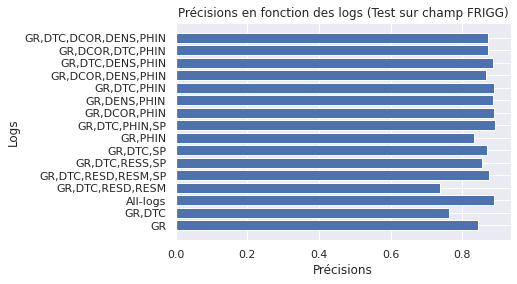

In [0]:
plt.barh(comb, prec_comb)
plt.xlabel('Précisions')
plt.ylabel('Logs')
plt.title('Précisions en fonction des logs (Test sur champ FRIGG)')

In [0]:
score_full_full, precision_full_full,proba_full_full = xgboost_class(X_train_not_frig, y_train_not_frig,X_test_frig, y_test_frig,params_train_not_frig)
print('Logs utilisés : [GR-DTC-DENS-PHIN]')
print('score avec toutes les données : '+str(score_full_full))
print('précision avec toutes les données : '+str(precision_full_full))

Logs utilisés : [GR-DTC-DENS-PHIN]
score avec toutes les données : 0.8641078838174274
précision avec toutes les données : 0.8437067773167358


In [0]:
fpr, tpr, thresholds = roc_curve(y_test_frig, proba_full_full[:,1],pos_label=1)

In [0]:
auc_full_full = auc(fpr,tpr)

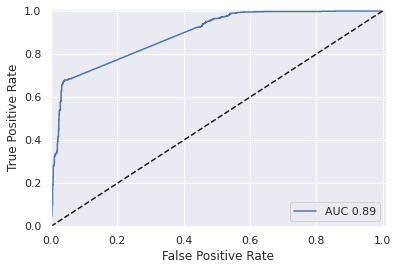

In [0]:
roc_courbe(fpr,tpr,auc_full_full)

In [0]:
score_full_clean, precision_full_clean, proba_full_clean = xgboost_class(X_train_not_frig, y_train_not_frig,X_test_frig_clean, y_test_frig_clean, params_train_not_frig)
print('Logs utilisés : [GR-DTC-DENS-PHIN]')
print('score avec toutes les données : '+str(score_full_clean))
print('précision avec toutes les données : '+str(precision_full_clean))

Logs utilisés : [GR-DTC-DENS-PHIN]
score avec toutes les données : 0.9192462987886945
précision avec toutes les données : 0.8702064896755162


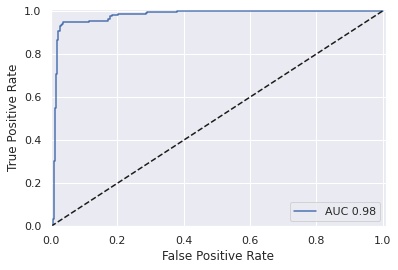

In [0]:
fpr1, tpr1, thresholds = roc_curve(y_test_frig_clean, proba_full_clean[:,1],pos_label=1)
auc_full_clean = auc(fpr1,tpr1)
roc_courbe(fpr1,tpr1,auc_full_clean)

In [0]:
score_clean_full, precision_clean_full, proba_clean_full= xgboost_class(X_train_not_frig_clean, y_train_not_frig_clean,X_test_frig, y_test_frig, params_train_not_frig_clean)
print('Logs utilisés : [GR-DTC-DENS-PHIN]')
print('score avec les données clean: '+str(score_clean_full))
print('précision avec les données clean : '+str(precision_clean_full))

Logs utilisés : [GR-DTC-DENS-PHIN]
score avec les données clean: 0.59716459197787
précision avec les données clean : 0.3924941360437842


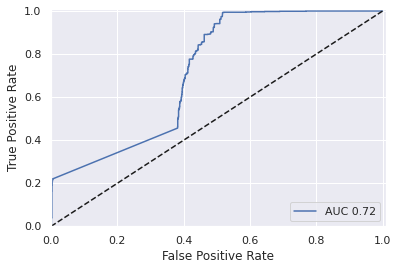

In [0]:
fpr, tpr, thresholds = roc_curve(y_test_frig, proba_clean_full[:,1],pos_label=1)
auc_clean_full = auc(fpr,tpr)
roc_courbe(fpr,tpr,auc_clean_full)

In [0]:
score_clean_clean, precision_clean_clean, proba_clean_clean = xgboost_class(X_train_not_frig_clean, y_train_not_frig_clean,X_test_frig_clean, y_test_frig_clean, params_train_not_frig_clean)
print('Logs utilisés : [GR-DTC-DENS-PHIN]')
print('score avec les données clean: '+str(score_clean_clean))
print('précision avec les données clean : '+str(precision_clean_clean))

Logs utilisés : [GR-DTC-DENS-PHIN]
score avec les données clean: 0.8882907133243607
précision avec les données clean : 0.9253731343283582


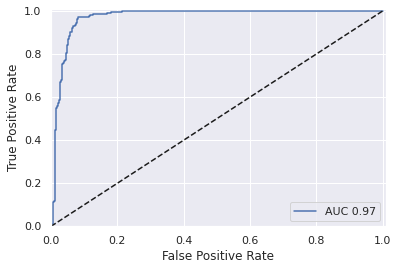

In [0]:
fpr2, tpr2, thresholds = roc_curve(y_test_frig_clean, proba_clean_clean[:,1],pos_label=1)
auc_clean_clean = auc(fpr2,tpr2)
roc_courbe(fpr2,tpr2,auc_clean_clean)

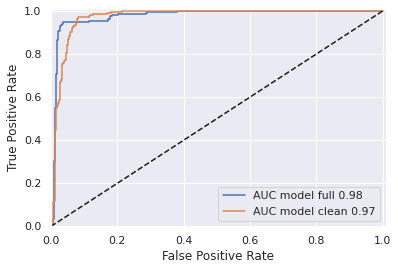

In [0]:
roc_courbe2(fpr1,tpr1,auc_full_clean,fpr2,tpr2, auc_clean_clean)

In [0]:
score_full_2_full, precision_full_2_full, proba_full_2_full = xgboost_class(X_train_not_frig_2, y_train_not_frig,X_test_frig_2, y_test_frig, params_train_not_frig_2)
print('Logs utilisés : [GR-DTC-DENS-DCOR-PHIN]')
print('score avec toutes les données : '+str(score_full_2_full))
print('précision avec toutes les données : '+str(precision_full_2_full))

Logs utilisés : [GR-DTC-DENS-DCOR-PHIN]
score avec toutes les données : 0.8001383125864454
précision avec toutes les données : 0.7736842105263158


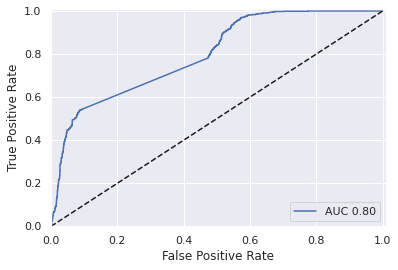

In [0]:
fpr, tpr, thresholds = roc_curve(y_test_frig, proba_full_2_full[:,1],pos_label=1)
auc_full_2_full = auc(fpr,tpr)
roc_courbe(fpr,tpr,auc_full_2_full)

In [0]:
score_full_2_clean, precision_full_2_clean, proba_full_2_clean = xgboost_class(X_train_not_frig_2, y_train_not_frig,X_test_frig_clean_2, y_test_frig_clean_2, params_train_not_frig_2)
print('Logs utilisés : [GR-DTC-DENS-DCOR-PHIN]')
print('score avec toutes les données : '+str(score_full_2_clean))
print('précision avec toutes les données : '+str(precision_full_2_clean))

Logs utilisés : [GR-DTC-DENS-DCOR-PHIN]
score avec toutes les données : 0.6920980926430518
précision avec toutes les données : 0.7225130890052356


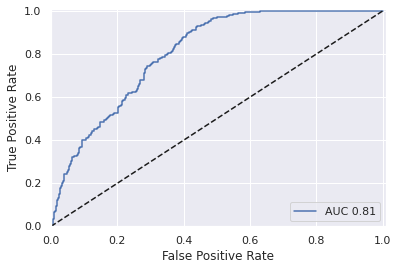

In [0]:
fpr1_2, tpr1_2, thresholds = roc_curve(y_test_frig_clean_2, proba_full_2_clean[:,1],pos_label=1)
auc_full_2_clean = auc(fpr1_2,tpr1_2)
roc_courbe(fpr1_2,tpr1_2,auc_full_2_clean)

In [0]:
score_clean_2_full, precision_clean_2_full, proba_clean_2_full = xgboost_class(X_train_not_frig_clean_2, y_train_not_frig_clean_2,X_test_frig_2, y_test_frig, params_train_not_frig_clean_2)
print('Logs utilisés : [GR-DTC-DENS-DCOR-PHIN]')
print('score avec les données clean: '+str(score_clean_2_full))
print('précision avec les données clean : '+str(precision_clean_2_full))

Logs utilisés : [GR-DTC-DENS-DCOR-PHIN]
score avec les données clean: 0.603042876901798
précision avec les données clean : 0.4051470588235294


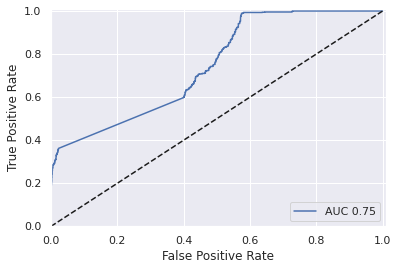

In [0]:
fpr, tpr, thresholds = roc_curve(y_test_frig, proba_clean_2_full[:,1],pos_label=1)
auc_clean_2_full = auc(fpr,tpr)
roc_courbe(fpr,tpr,auc_clean_2_full)

In [0]:
score_clean_2_clean, precision_clean_2_clean, proba_clean_2_clean = xgboost_class(X_train_not_frig_clean_2, y_train_not_frig_clean_2,X_test_frig_clean_2, y_test_frig_clean_2, params_train_not_frig_clean_2)
print('Logs utilisés : [GR-DTC-DENS-DCOR-PHIN]')
print('score avec les données clean: '+str(score_clean_2_clean))
print('précision avec les données clean : '+str(precision_clean_2_clean))

Logs utilisés : [GR-DTC-DENS-DCOR-PHIN]
score avec les données clean: 0.9100817438692098
précision avec les données clean : 0.8678678678678678


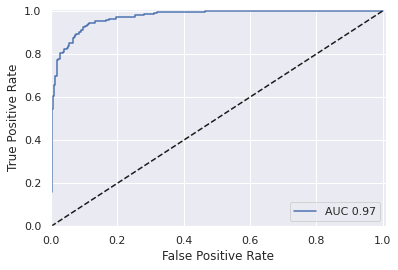

In [0]:
fpr2_2, tpr2_2, thresholds = roc_curve(y_test_frig_clean_2, proba_clean_2_clean[:,1],pos_label=1)
auc_clean_2_clean = auc(fpr2_2,tpr2_2)
roc_courbe(fpr2_2,tpr2_2,auc_clean_2_clean)

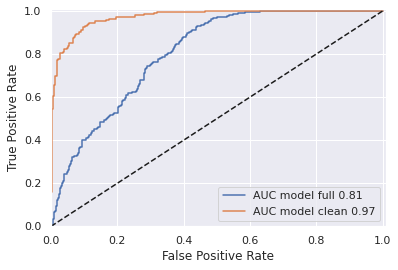

In [0]:
roc_courbe2(fpr1_2,tpr1_2, auc_full_2_clean, fpr2_2, tpr2_2,auc_clean_2_clean)

Text(0.5, 1.0, 'Précisions basées sur les logs GR-DTC-DENS-PHIN (puits FRIGG en test)')

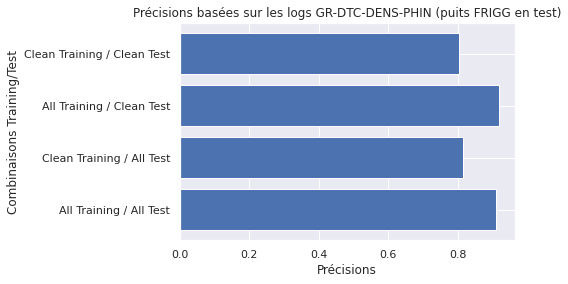

In [0]:
index_x = [ 'All Training / All Test','Clean Training / All Test','All Training / Clean Test', 'Clean Training / Clean Test' ]
precisions_x = [precision_full_full, precision_clean_full, precision_full_clean,precision_clean_clean]
plt.barh(index_x, precisions_x)
plt.xlabel('Précisions')
plt.ylabel('Combinaisons Training/Test')
plt.title('Précisions basées sur les logs GR-DTC-DENS-PHIN (puits FRIGG en test)')

Text(0.5, 1.0, 'Précisions basées sur les logs GR-DTC-DENS-DCOR-PHIN (puits FRIGG en test)')

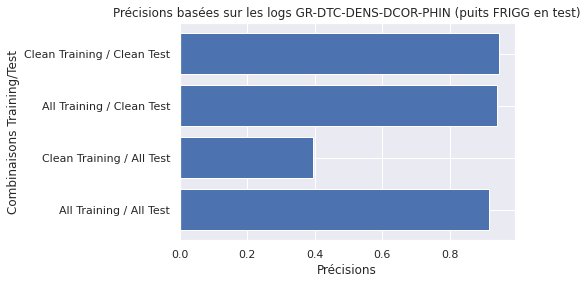

In [0]:
index_x = [ 'All Training / All Test','Clean Training / All Test','All Training / Clean Test', 'Clean Training / Clean Test' ]
precisions_x = [precision_full_2_full, precision_clean_2_full, precision_full_2_clean,precision_clean_2_clean]
plt.barh(index_x, precisions_x)
plt.xlabel('Précisions')
plt.ylabel('Combinaisons Training/Test')
plt.title('Précisions basées sur les logs GR-DTC-DENS-DCOR-PHIN (puits FRIGG en test)')

#11-**Modélisation en prenant 6 autres puits comme jeu de données Test**

In [0]:
comb = ["GR","GR,DTC", "All-logs", "GR,DTC,RESD,RESM","GR,DTC,RESD,RESM,SP", "GR,DTC,RESS,SP","GR,DTC,SP","GR,PHIN","GR,DTC,PHIN,SP", 
           "GR,DCOR,PHIN","GR,DENS,PHIN", "GR,DTC,PHIN", "GR,DCOR,DENS,PHIN", "GR,DTC,DENS,PHIN", "GR,DCOR,DTC,PHIN",
           "GR,DTC,DCOR,DENS,PHIN"]

In [0]:
#well_test = ['10/1-A-19', '10/1-A-18', '10/1-A-12', '10/1-A-14', '11/30A-A1', '11/30A-A28','13/30-3', '11/30-2','11/30A-A26Z','11/30A-A27']
well_test = [ '11/30A-A1', '11/30A-A28','13/30-3', '11/30-2','11/30A-A26Z','11/30A-A27']
well_others = [ '10/1-A-19', '10/1-A-18', '10/1-A-12', '10/1-A-14','11/30A-A1', '11/30A-A28','13/30-3', '11/30-2','11/30A-A26Z','11/30A-A27']

In [0]:
data_geox_test = data_geox[data_geox['WELL'].isin(well_test)]
data_geox_train = data_geox[data_geox['WELL'].isin(well_others) == False ]

In [0]:
data_geox_train.shape

(414393, 15)

In [0]:
data_geox_test.shape

(44940, 15)

In [0]:
data_geox_train.head()

WELL       GR      CAL   DCOR  ...  RESMIC       SP   DEPTH_M  LITHO
0  10/1-A-10  17.2000  8.48605 -0.275  ...     NaN -22.2857  2094.872      0
1  10/1-A-10  18.7058  8.56870 -0.275  ...     NaN -20.0000  2095.024      0
2  10/1-A-10  19.3092  8.62140 -0.275  ...     NaN -18.2857  2095.176      0
3  10/1-A-10  19.1081  8.71425 -0.275  ...     NaN -16.5714  2095.328      0
4  10/1-A-10  20.3536  8.93990 -0.168  ...     NaN -15.1429  2095.480      0

[5 rows x 15 columns]

In [0]:
prec_comb = []
prec_proba = []
for col in comb:
  print(col.split(','))
  if col == 'All-logs':
    X_train = data_geox_train.drop(columns=['WELL', 'DEPTH_M', 'LITHO' ])
    y_train = data_geox_train['LITHO']
    X_test = data_geox_test.drop(columns=['WELL', 'DEPTH_M', 'LITHO' ])
    y_test = data_geox_test['LITHO']
  else:
    X_train = data_geox_train[col.split(',')]
    y_train = data_geox_train['LITHO']
    X_test = data_geox_test[col.split(',')]
    y_test = data_geox_test['LITHO']
  score, precision = xgboost_class(X_train, y_train,X_test, y_test)
  prec_comb.append(precision)

['GR']
['GR', 'DTC']
['All-logs']
['GR', 'DTC', 'RESD', 'RESM']
['GR', 'DTC', 'RESD', 'RESM', 'SP']
['GR', 'DTC', 'RESS', 'SP']
['GR', 'DTC', 'SP']
['GR', 'PHIN']
['GR', 'DTC', 'PHIN', 'SP']
['GR', 'DCOR', 'PHIN']
['GR', 'DENS', 'PHIN']
['GR', 'DTC', 'PHIN']
['GR', 'DCOR', 'DENS', 'PHIN']
['GR', 'DTC', 'DENS', 'PHIN']
['GR', 'DCOR', 'DTC', 'PHIN']
['GR', 'DTC', 'DCOR', 'DENS', 'PHIN']


In [0]:
prec_comb

[0.7736631837738168,
 0.4886330831408776,
 0.8094083192239052,
 0.6795116928960141,
 0.7061774616248596,
 0.5741512805241215,
 0.48218700014541227,
 0.720239580733716,
 0.7767993696992168,
 0.7955885275220242,
 0.6802241017076981,
 0.7151277013752456,
 0.786529753173034,
 0.7026022304832714,
 0.7299420064843144,
 0.7482282886736277]

Text(0.5, 1.0, 'Précisions en fonction des logs')

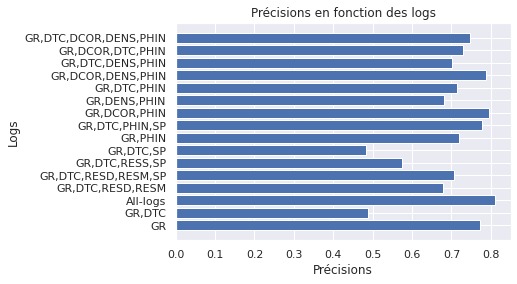

In [0]:
plt.barh(comb, prec_comb)
plt.xlabel('Précisions')
plt.ylabel('Logs')
plt.title('Précisions en fonction des logs')

In [0]:
data_geox_train_ext = pd.DataFrame(data_geox_train.isnull().sum()/len(data_geox_train)*100)
data_geox_test_ext = pd.DataFrame(data_geox_test.isnull().sum()/len(data_geox_test)*100)

In [0]:
data_geox_train_ext.T.head()

WELL        GR        CAL       DCOR  ...     RESMIC         SP  DEPTH_M  LITHO
0   0.0  0.924485  57.066118  62.782431  ...  88.569064  48.437353      0.0    0.0

[1 rows x 15 columns]

In [0]:
data_geox_test_ext.T.head()

WELL        GR       CAL       DCOR  ...     RESMIC         SP  DEPTH_M  LITHO
0   0.0  2.661326  41.53093  42.300846  ...  95.289275  59.959947      0.0    0.0

[1 rows x 15 columns]

In [0]:
cols_x = ['GR', 'DTC', 'RESD', 'RESM', 'SP']
cols_x_2 = ['GR','DTC','DENS','DCOR','PHIN']

In [0]:
X_train = data_geox_train[cols_x]
y_train = data_geox_train['LITHO']

In [0]:
params_train = tuning_params(X_train, y_train)

In [0]:
params_train.to_csv("/content/drive/My Drive/datas/params_train.csv")
params_train.head()

subsample  silent  reg_lambda  ...  gamma  colsample_bytree  colsample_bylevel
0        0.7   False        10.0  ...    0.0               0.8                0.4

[1 rows x 10 columns]

In [0]:
X_train_2 = data_geox_train[cols_x_2]

In [0]:
params_train_2 = tuning_params(X_train_2, y_train)

In [0]:
params_train_2.to_csv("/content/drive/My Drive/datas/params_train_2.csv")
params_train_2.head()

subsample  silent  reg_lambda  ...  gamma  colsample_bytree  colsample_bylevel
0        0.6   False         5.0  ...    0.5               0.9                0.4

[1 rows x 10 columns]

In [0]:
data_geox_train[cols_x].dropna().index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            356976, 356977, 356978, 356979, 356980, 356981, 356982, 356983,
            356984, 356985],
           dtype='int64', length=117924)

In [0]:
X_train_clean = data_geox_train[cols_x].dropna()
y_train_clean = data_geox_train['LITHO'].loc[data_geox_train[cols_x].dropna().index]

In [0]:
params_train_clean = tuning_params(X_train_clean, y_train_clean)

In [0]:
params_train_clean.to_csv("/content/drive/My Drive/datas/params_train_clean.csv")
params_train_clean.head()

subsample  silent  reg_lambda  ...  gamma  colsample_bytree  colsample_bylevel
0        0.9   False        50.0  ...   0.25               0.7                0.4

[1 rows x 10 columns]

In [0]:
X_train_clean_2 = data_geox_train[cols_x_2].dropna()
y_train_clean_2 = data_geox_train['LITHO'].loc[data_geox_train[cols_x_2].dropna().index]

In [0]:
params_train_clean_2 = tuning_params(X_train_clean_2, y_train_clean_2)

In [0]:
params_train_clean_2.to_csv("/content/drive/My Drive/datas/params_train_clean_2.csv")
params_train_clean_2.head()

subsample  silent  reg_lambda  ...  gamma  colsample_bytree  colsample_bylevel
0        0.6   False         1.0  ...    0.0               0.7                0.7

[1 rows x 10 columns]

In [0]:
X_test = data_geox_test[cols_x]
y_test = data_geox_test['LITHO']

In [0]:
X_test_clean = data_geox_test[cols_x].dropna()
y_test_clean = data_geox_test['LITHO'].loc[data_geox_test[cols_x].dropna().index]

In [0]:
print(X_train_clean.shape)

(117924, 5)


In [0]:
print(X_test_clean.shape)

(10399, 5)


In [0]:
X_test_2 = data_geox_test[cols_x_2]

In [0]:
X_test_clean_2 = data_geox_test[cols_x_2].dropna()
y_test_clean_2 = data_geox_test['LITHO'].loc[data_geox_test[cols_x_2].dropna().index]

In [0]:
print(X_test_clean_2.shape)

(7463, 5)


In [0]:
print(X_train_clean_2.shape)

(129779, 5)


In [0]:
score_full_full, precision_full_full, proba_full_full = xgboost_class(X_train, y_train,X_test, y_test, params_train)
print('Logs utilisés : [GR-DTC-RESD-RESM-SP]')
print('score avec toutes les données : '+str(score_full_full))
print('précision avec toutes les données : '+str(precision_full_full))

Logs utilisés : [GR-DTC-RESD-RESM-SP]
score avec toutes les données : 0.7568980863373387
précision avec toutes les données : 0.7731902689873418


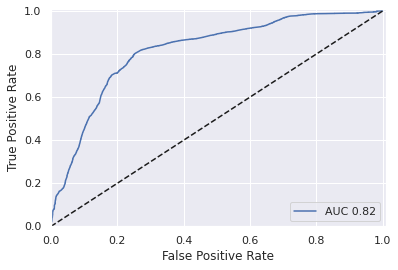

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, proba_full_full[:,1],pos_label=1)
auc_full_full = auc(fpr,tpr)
roc_courbe(fpr,tpr,auc_full_full)

In [0]:
score_full_clean, precision_full_clean, proba_full_clean = xgboost_class(X_train, y_train,X_test_clean, y_test_clean, params_train)
print('Logs utilisés : [GR-DTC-RESD-RESM-SP]')
print('score avec toutes les données : '+str(score_full_clean))
print('précision avec toutes les données : '+str(precision_full_clean))

Logs utilisés : [GR-DTC-RESD-RESM-SP]
score avec toutes les données : 0.5423598422925281
précision avec toutes les données : 0.40876068376068375


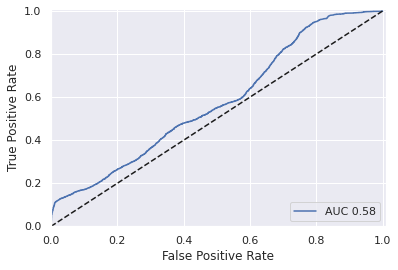

In [0]:
fpr1, tpr1, thresholds = roc_curve(y_test_clean, proba_full_clean[:,1],pos_label=1)
auc_full_clean = auc(fpr1,tpr1)
roc_courbe(fpr1,tpr1,auc_full_clean)

In [0]:
score_clean_full, precision_clean_full, proba_clean_full = xgboost_class(X_train_clean, y_train_clean,X_test, y_test, params_train_clean)
print('Logs utilisés : [GR-DTC-RESD-RESM-SP]')
print('score avec les données clean: '+str(score_clean_full))
print('précision avec les données clean : '+str(precision_clean_full))

Logs utilisés : [GR-DTC-RESD-RESM-SP]
score avec les données clean: 0.5666889185580775
précision avec les données clean : 0.5511865793780687


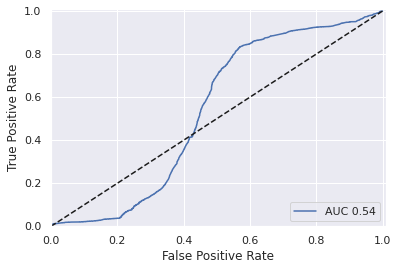

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, proba_clean_full[:,1],pos_label=1)
auc_clean_full = auc(fpr,tpr)
roc_courbe(fpr,tpr,auc_clean_full)

In [0]:
score_clean_clean, precision_clean_clean, proba_clean_clean = xgboost_class(X_train_clean, y_train_clean,X_test_clean, y_test_clean, params_train_clean)
print('Logs utilisés : [GR-DTC-RESD-RESM-SP]')
print('score avec les données clean: '+str(score_clean_clean))
print('précision avec les données clean : '+str(precision_clean_clean))

Logs utilisés : [GR-DTC-RESD-RESM-SP]
score avec les données clean: 0.49956726608327723
précision avec les données clean : 0.33943139678615575


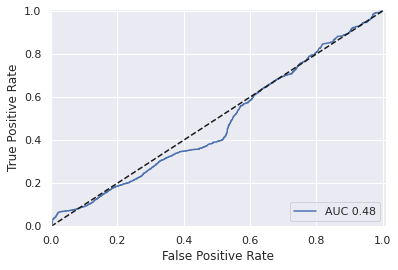

In [0]:
fpr2, tpr2, thresholds = roc_curve(y_test_clean, proba_clean_clean[:,1],pos_label=1)
auc_clean_clean = auc(fpr2,tpr2)
roc_courbe(fpr2,tpr2,auc_clean_clean)

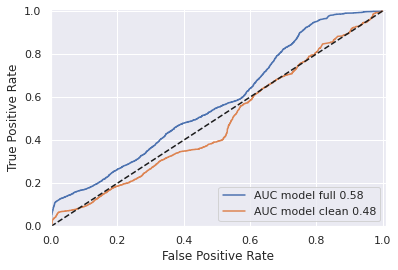

In [0]:
roc_courbe2(fpr1, tpr1,auc_full_clean, fpr2,tpr2, auc_clean_clean)

In [0]:
score_full_2_full, precision_full_2_full, proba_full_2_full= xgboost_class(X_train_2, y_train,X_test_2, y_test, params_train_2)
print('Logs utilisés : [GR-DTC-DENS-DCOR-PHIN]')
print('score avec toutes les données : '+str(score_full_2_full))
print('précision avec toutes les données : '+str(precision_full_2_full))

Logs utilisés : [GR-DTC-DENS-DCOR-PHIN]
score avec toutes les données : 0.6294170004450378
précision avec toutes les données : 0.6644822256568779


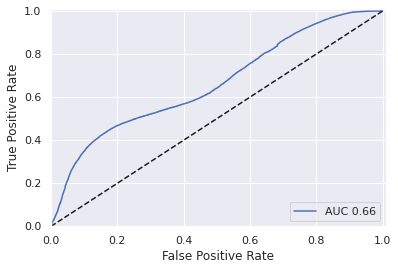

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, proba_full_2_full[:,1],pos_label=1)
auc_full_2_full = auc(fpr,tpr)
roc_courbe(fpr,tpr,auc_full_2_full)

In [0]:
score_full_2_clean, precision_full_2_clean, proba_full_2_clean = xgboost_class(X_train_2, y_train,X_test_clean_2, y_test_clean_2, params_train_2)
print('Logs utilisés : [GR-DTC-DENS-DCOR-PHIN]')
print('score avec toutes les données : '+str(score_full_2_clean))
print('précision avec toutes les données : '+str(precision_full_2_clean))

Logs utilisés : [GR-DTC-DENS-DCOR-PHIN]
score avec toutes les données : 0.6881950958059762
précision avec toutes les données : 0.5380697050938338


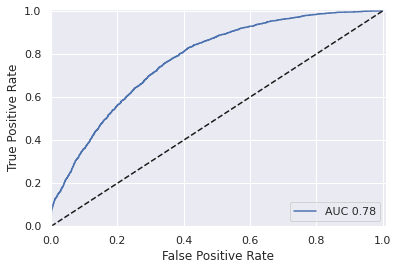

In [0]:
fpr1_2, tpr1_2, thresholds = roc_curve(y_test_clean_2, proba_full_2_clean[:,1],pos_label=1)
auc_full_2_clean = auc(fpr1_2,tpr1_2)
roc_courbe(fpr1_2,tpr1_2,auc_full_2_clean)

In [0]:
score_clean_2_full, precision_clean_2_full, proba_clean_2_full = xgboost_class(X_train_clean_2, y_train_clean_2,X_test_2, y_test, params_train_clean_2)
print('Logs utilisés : [GR-DTC-DENS-DCOR-PHIN]')
print('score avec les données clean: '+str(score_clean_2_full))
print('précision avec les données clean : '+str(precision_clean_2_full))

Logs utilisés : [GR-DTC-DENS-DCOR-PHIN]
score avec les données clean: 0.5682242990654206
précision avec les données clean : 0.5571663627873883


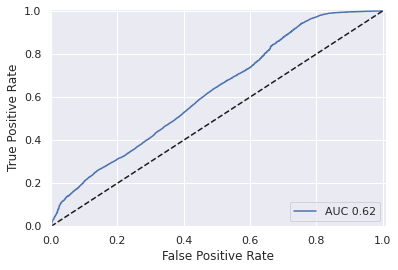

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, proba_clean_2_full[:,1],pos_label=1)
auc_clean_2_full = auc(fpr,tpr)
roc_courbe(fpr,tpr,auc_clean_2_full)

In [0]:
score_clean_2_clean, precision_clean_2_clean, proba_clean_2_clean = xgboost_class(X_train_clean_2, y_train_clean_2,X_test_clean_2, y_test_clean_2, params_train_clean_2)
print('Logs utilisés : [GR-DTC-DENS-DCOR-PHIN]')
print('score avec les données clean: '+str(score_clean_2_clean))
print('précision avec les données clean : '+str(precision_clean_2_clean))

Logs utilisés : [GR-DTC-DENS-DCOR-PHIN]
score avec les données clean: 0.7021305105185582
précision avec les données clean : 0.5502851218247797


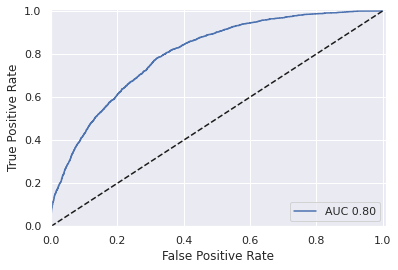

In [0]:
fpr2_2, tpr2_2, thresholds = roc_curve(y_test_clean_2, proba_clean_2_clean[:,1],pos_label=1)
auc_clean_2_clean = auc(fpr2_2,tpr2_2)
roc_courbe(fpr2_2,tpr2_2,auc_clean_2_clean)

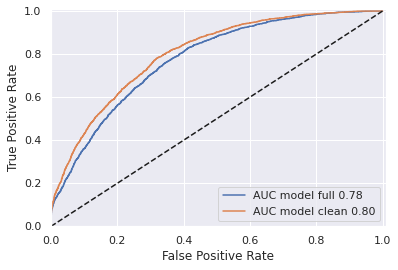

In [0]:
roc_courbe2(fpr1_2, tpr1_2, auc_full_2_clean, fpr2_2, tpr2_2, auc_clean_2_clean)

Text(0.5, 1.0, 'Précisions basées sur les logs GR-DTC-RESD-RESM-SP (6 puits en test)')

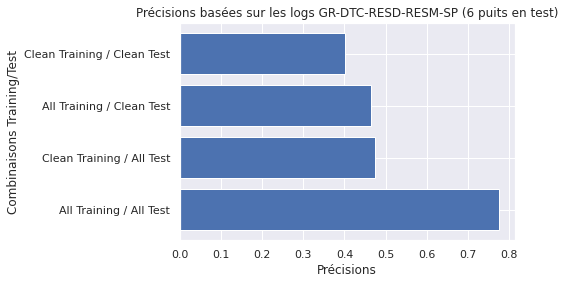

In [0]:
index_x = [ 'All Training / All Test','Clean Training / All Test','All Training / Clean Test', 'Clean Training / Clean Test' ]
precisions_x = [precision_full_full, precision_clean_full, precision_full_clean,precision_clean_clean]
plt.barh(index_x, precisions_x)
plt.xlabel('Précisions')
plt.ylabel('Combinaisons Training/Test')
plt.title('Précisions basées sur les logs GR-DTC-RESD-RESM-SP (6 puits en test)')

Text(0.5, 1.0, 'Précisions basées sur les logs GR-DTC-DENS-DCOR-PHIN (6 puits en test)')

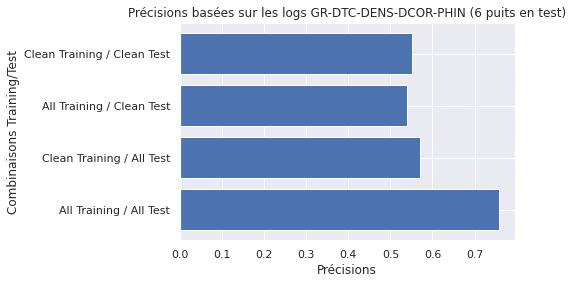

In [0]:
index_x = [ 'All Training / All Test','Clean Training / All Test','All Training / Clean Test', 'Clean Training / Clean Test' ]
precisions_x = [precision_full_2_full, precision_clean_2_full, precision_full_2_clean,precision_clean_2_clean]
plt.barh(index_x, precisions_x)
plt.xlabel('Précisions')
plt.ylabel('Combinaisons Training/Test')
plt.title('Précisions basées sur les logs GR-DTC-DENS-DCOR-PHIN (6 puits en test)')

#12-**Modélisation LeaveOneGroupOut**

In [0]:
X = data_geox[cols_x]
y = data_geox['LITHO']

In [0]:
X_2 = data_geox[cols_x_2]
y_2 = data_geox['LITHO']

In [0]:
groups = data_geox.WELL.values
logo = LeaveOneGroupOut()
logo.get_n_splits(groups=groups)

61

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


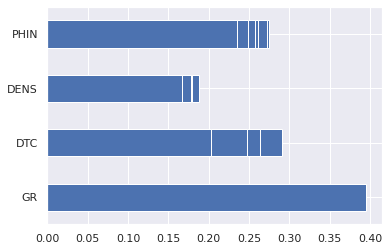

In [0]:
scores = []
precisions = []
count = 0
i = 0
index_test = {}
index_train = {}
for train_index, test_index in logo.split(X, y, groups=groups):
  #print(i)
  X_train, X_test = X.loc[train_index], X.loc[test_index]
  y_train, y_test = y.loc[train_index], y.loc[test_index]
  model = XGBClassifier(tree_method='gpu_hist', gpu_id=0)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  score = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  scores.append(score)
  precisions.append(precision)
  index_test[count] = test_index
  index_train[count] = train_index
  (pd.Series(model.feature_importances_, index=X_train.columns).plot(kind='barh')) 
  i+=1
  count+=1
  #print(score)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


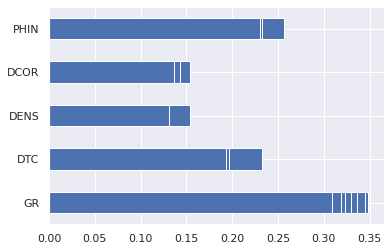

In [0]:
scores_2 = []
precisions_2 = []
count = 0
i = 0
index_test = {}
index_train = {}
for train_index, test_index in logo.split(X_2, y_2, groups=groups):
  #print(i)
  X_train, X_test = X_2.loc[train_index], X_2.loc[test_index]
  y_train, y_test = y_2.loc[train_index], y_2.loc[test_index]
  model = XGBClassifier(tree_method='gpu_hist', gpu_id=0)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  score = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  scores_2.append(score)
  precisions_2.append(precision)
  index_test[count] = test_index
  index_train[count] = train_index
  (pd.Series(model.feature_importances_, index=X_train.columns).plot(kind='barh')) 
  i+=1
  count+=1
  #print(score)

In [0]:
X_not_na = data_geox[cols_x].dropna().reset_index(drop=True)
y_not_na = data_geox['LITHO'].loc[data_geox[cols_x].dropna().index].reset_index(drop=True)

In [0]:
X_not_na_2= data_geox[cols_x_2].dropna().reset_index(drop=True)
y_not_na_2 = data_geox['LITHO'].loc[data_geox[cols_x_2].dropna().index].reset_index(drop=True)

In [0]:
groups_1 = data_geox['WELL'].loc[data_geox[cols_x].dropna().index]
logo = LeaveOneGroupOut()
logo.get_n_splits(groups=groups_1)

38

In [0]:
groups_2 = data_geox['WELL'].loc[data_geox[cols_x_2].dropna().index]
logo = LeaveOneGroupOut()
logo.get_n_splits(groups=groups_2)

36

In [0]:
data_geox[cols_x_2][(data_geox['WELL'] == '11/30A-B10') & (data_geox['LITHO'] == 1) ].shape

(3158, 5)

In [0]:
data_geox[cols_x_2].dropna()[(data_geox['WELL'] == '11/30A-B10') & (data_geox['LITHO'] == 1) ].shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(42, 5)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


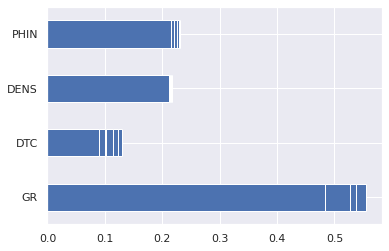

In [0]:
scores_not_na = []
precisions_not_na = []
count = 0
i = 0
index_test = {}
index_train = {}
for train_index, test_index in logo.split(X_not_na, y_not_na, groups=groups_1):
  #print(i)
  X_train, X_test = X_not_na.loc[train_index], X_not_na.loc[test_index]
  y_train, y_test = y_not_na.loc[train_index], y_not_na.loc[test_index]
  model = XGBClassifier(tree_method='gpu_hist', gpu_id=0)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  score = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  scores_not_na.append(score)
  precisions_not_na.append(precision)
  index_test[count] = test_index
  index_train[count] = train_index
  (pd.Series(model.feature_importances_, index=X_train.columns).plot(kind='barh')) 
  i+=1
  count+=1
  #print(score)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


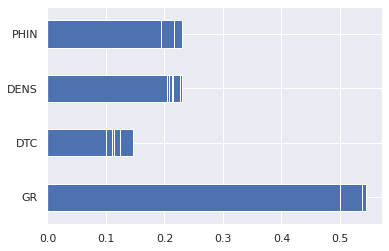

In [0]:
scores_not_na_2 = []
precisions_not_na_2 = []
count = 0
i = 0
index_test = {}
index_train = {}
for train_index, test_index in logo.split(X_not_na_2, y_not_na_2, groups=groups_2):
  #print(i)
  X_train, X_test = X_not_na.loc[train_index], X_not_na.loc[test_index]
  y_train, y_test = y_not_na.loc[train_index], y_not_na.loc[test_index]
  model = XGBClassifier(tree_method='gpu_hist', gpu_id=0)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  score = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  scores_not_na_2.append(score)
  precisions_not_na_2.append(precision)
  index_test[count] = test_index
  index_train[count] = train_index
  (pd.Series(model.feature_importances_, index=X_train.columns).plot(kind='barh')) 
  i+=1
  count+=1
  #print(score)

In [0]:
well_38 = data_geox['WELL'].loc[data_geox[cols_x].dropna().index].unique().tolist()

In [0]:
well_36 = data_geox['WELL'].loc[data_geox[cols_x_2].dropna().index].unique().tolist()

In [0]:
well_int_38 = sorted(list(set(well) & set(well_38)))

In [0]:
well_int_36 = sorted(list(set(well) & set(well_36)))

In [0]:
precisions_int_38 = []
for i in well_int_38:
  for j in range(len(well)):
    if i == well[j]:
      precisions_int_38.append(precisions[j])

In [0]:
precisions_int_36 = []
for i in well_int_36:
  for j in range(len(well)):
    if i == well[j]:
      precisions_int_36.append(precisions_2[j])

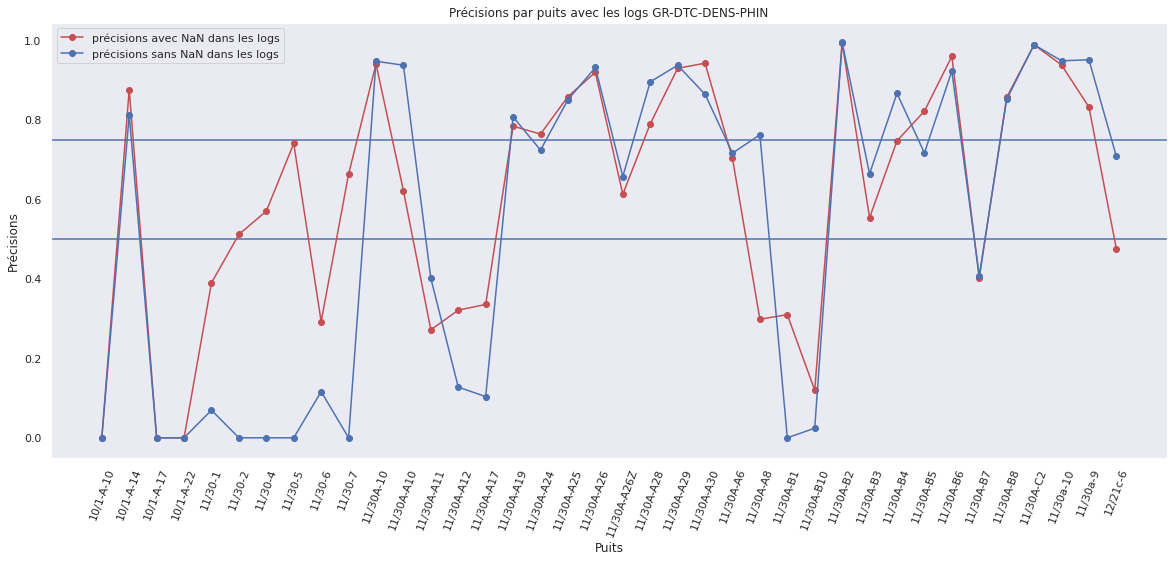

In [0]:
plt.figure(figsize=(20,8))
plt.grid()
plt.axhline(y=0.5)
plt.axhline(y=0.75)
plt.title('Précisions par puits avec les logs GR-DTC-DENS-PHIN')
plt.plot(well_int_38, precisions_int_38 , 'ro-', label='précisions avec NaN dans les logs')
plt.plot(well_38, precisions_not_na, 'bo-', label='précisions sans NaN dans les logs')
plt.xlabel('Puits')
plt.xticks(rotation=70)
plt.ylabel('Précisions')
plt.legend()

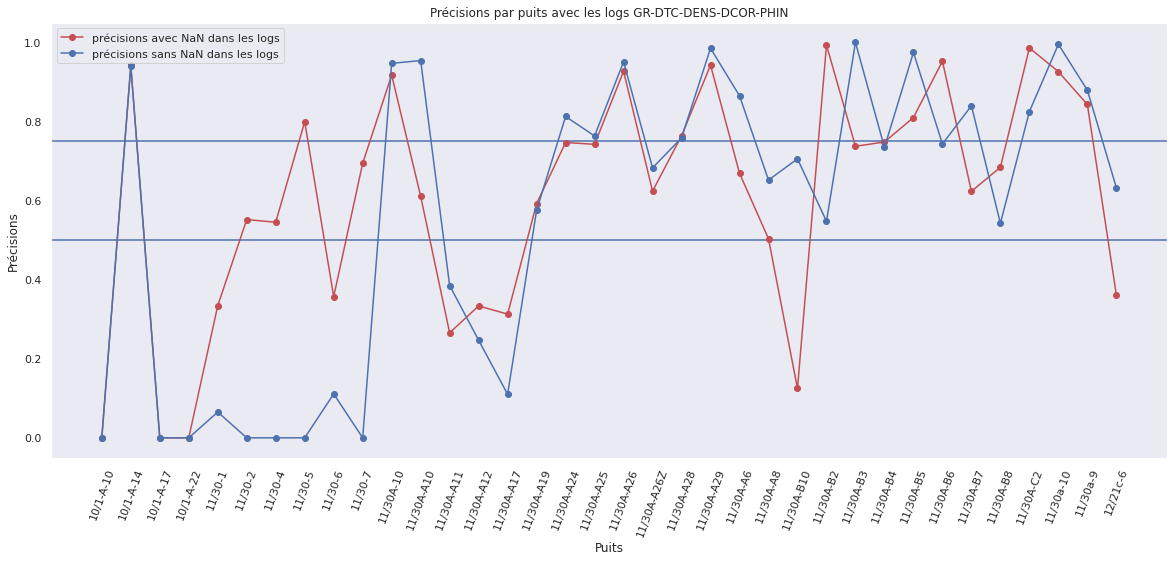

In [0]:
plt.figure(figsize=(20,8))
plt.grid()
plt.axhline(y=0.5)
plt.axhline(y=0.75)
plt.title('Précisions par puits avec les logs GR-DTC-DENS-DCOR-PHIN')
plt.plot(well_int_36, precisions_int_36 , 'ro-', label='précisions avec NaN dans les logs')
plt.plot(well_36, precisions_not_na_2, 'bo-', label='précisions sans NaN dans les logs')
plt.xlabel('Puits')
plt.xticks(rotation=70)
plt.ylabel('Précisions')
plt.legend()

**Tuning des hyper paramètres**

In [0]:
rs_clf = RandomizedSearchCV(xgb, param_grid, n_iter=20,
                            n_jobs=1, verbose=2, cv=2,
                            scoring='neg_root_mean_squared_error', refit=False, random_state=42)
rs_clf.fit(X_train_not_frig, y_train_not_frig)

In [0]:
rs_clf.best_params_

{'colsample_bylevel': 0.7,
 'colsample_bytree': 0.5,
 'gamma': 0,
 'learning_rate': 0.001,
 'max_depth': 15,
 'min_child_weight': 10.0,
 'n_estimators': 500,
 'reg_lambda': 1.0,
 'silent': False,
 'subsample': 0.6}

In [0]:
model = XGBClassifier(learning_rate=0.08, max_depth=14, n_estimators=100, tree_method='gpu_hist', gpu_id=0)

model.fit(X_train_not_frig, y_train_not_frig)
y_pred = model.predict(X_test_frig)
score = accuracy_score(y_test_frig, y_pred)
print(score)
precision = precision_score(y_test_frig, y_pred)
print(precision)

0.8416320885200553
0.726890756302521


In [0]:
model.feature_importances_

array([0.08749723, 0.09788661, 0.05619146, 0.05182628, 0.07084153,
       0.05055239, 0.04097187, 0.09016664, 0.08685233, 0.17911258,
       0.08060892, 0.10749216], dtype=float32)

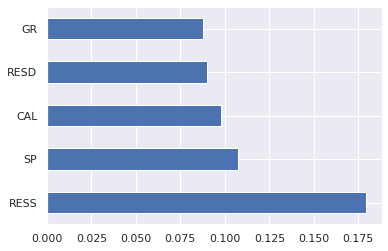

In [0]:
(pd.Series(model.feature_importances_, index=X_train_not_frig.columns).nlargest(5).plot(kind='barh')) 

In [0]:
data_geox_frig['LITHO_PRED'] = y_pred

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
data_geox_frig.head()

WELL         GR   CAL    DCOR  ...        SP   DEPTH_M  LITHO  LITHO_PRED
752  10/1-A-12  49.372267  8.45  0.0241  ...  134.6389  1894.992      1           0
753  10/1-A-12  49.002533  8.50  0.0040  ...  136.0000  1895.144      1           1
754  10/1-A-12  48.600867  8.50  0.0020  ...  136.7778  1895.296      1           1
755  10/1-A-12  48.801700  8.50  0.0040  ...  137.3889  1895.448      1           1
756  10/1-A-12  47.828300  8.55  0.0221  ...  137.7500  1895.600      1           0

[5 rows x 16 columns]

In [0]:
data_frig_mod2 = pd.read_csv("/content/drive/My Drive/datas/frigg_clean.csv")

In [0]:
data_frig_mod2.head()

DEPTH       GR      PHIN   DENS  ...   DEPTH_M       WELL LITHO LITHO_VF
0  2117.064  34.9600  0.227032  2.026  ...  2117.064  10/1-A-11  SAND        0
1  2117.216  36.7946  0.225890  1.994  ...  2117.216  10/1-A-11  SAND        0
2  2117.368  38.3555  0.231762  2.012  ...  2117.368  10/1-A-11  SAND        0
3  2117.520  37.2073  0.215568  2.018  ...  2117.520  10/1-A-11  SAND        0
4  2117.672  33.3755  0.180453  2.006  ...  2117.672  10/1-A-11  SAND        0

[5 rows x 9 columns]

In [0]:
data_geox_frig[data_geox_frig['DEPTH_M'] == 2117.520]

Empty DataFrame
Columns: [WELL, GR, CAL, DCOR, DENS, DTC, PE, PHIN, RESD, RESM, RESS, RESMIC, SP, DEPTH_M, LITHO, LITHO_PRED]
Index: []

In [0]:
data_frig_mod2.shape

(4338, 9)

In [0]:
data_frig_mod2.WELL.unique()

array(['10/1-A-11', '10/1-A-19', '10/1-A-15', '10/1-A-23', '10/1-A-12',
       '10/1-A-13', '10/1-A-16', '10/1-A-21', '10/1-A-17', '10/1-A-10',
       '10/1-A-20', '10/1-A-14', '10/1-A-22'], dtype=object)

In [0]:
data_frig_mod2['LITHO_VF'][data_frig_mod2['LITHO_VF'] == 1].count()

54

In [0]:
data_frig_mod2 = data_frig_mod2.set_index(['WELL', 'DEPTH_M'])

In [0]:
data_frig_mod2.head()

DEPTH       GR      PHIN   DENS    SP LITHO  LITHO_VF
WELL      DEPTH_M                                                           
10/1-A-11 2117.064  2117.064  34.9600  0.227032  2.026  18.5  SAND         0
          2117.216  2117.216  36.7946  0.225890  1.994  19.5  SAND         0
          2117.368  2117.368  38.3555  0.231762  2.012  20.5  SAND         0
          2117.520  2117.520  37.2073  0.215568  2.018  22.0  SAND         0
          2117.672  2117.672  33.3755  0.180453  2.006  23.0  SAND         0

In [0]:
data_geox_frig = data_geox_frig.set_index(['WELL', 'DEPTH_M'])

In [0]:
result = pd.merge(data_frig_mod2, data_geox_frig, on=['WELL', 'DEPTH_M'])

In [0]:
result.head()

DEPTH     GR_x    PHIN_x  ...   SP_y  LITHO_y LITHO_PRED
WELL      DEPTH_M                                ...                           
10/1-A-19 1910.040  1910.040  18.6422  0.185948  ... -103.5        0          0
          1910.192  1910.192  22.9866  0.188103  ... -101.5        0          0
          1910.344  1910.344  26.8516  0.190212  ...  -99.0        0          0
          1910.496  1910.496  28.3843  0.172968  ...  -98.0        0          0
          1910.648  1910.648  29.6386  0.156685  ...  -95.5        0          0

[5 rows x 21 columns]

In [0]:
result['LITHO_y'][result['LITHO_y'] == 1].count()

54

In [0]:
result['LITHO_y'][result['LITHO_y'] == 0].count()

986

In [0]:
precision_score(result['LITHO_y'], result['LITHO_PRED'])

0.8518518518518519

Text(0.5, 1.0, 'Précisions en fonction des logs')

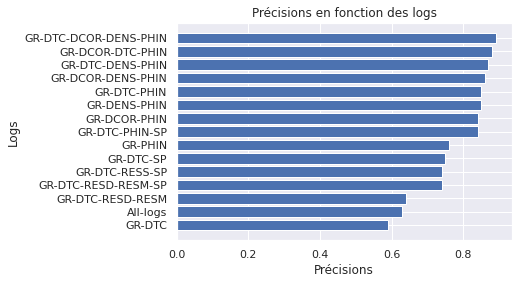

In [0]:
index_x = ['GR-DTC', 'All-logs', 'GR-DTC-RESD-RESM','GR-DTC-RESD-RESM-SP', 'GR-DTC-RESS-SP','GR-DTC-SP','GR-PHIN','GR-DTC-PHIN-SP', 
           'GR-DCOR-PHIN','GR-DENS-PHIN', 'GR-DTC-PHIN', 'GR-DCOR-DENS-PHIN', 'GR-DTC-DENS-PHIN', 'GR-DCOR-DTC-PHIN',
           'GR-DTC-DCOR-DENS-PHIN']
precisions_x = [0.59,0.63,0.64,0.74,0.74,0.75,0.76,0.84,0.84,0.85,0.85,0.86,0.87,0.88,0.89]
plt.barh(index_x, precisions_x)
plt.xlabel('Précisions')
plt.ylabel('Logs')
plt.title('Précisions en fonction des logs')

## Visualisation Arbre de décision et SHAP

#### Test en retirant un puit bien prédit 10/1-A-10

In [0]:
from xgboost import plot_tree

In [0]:
data_geox_good = data_geox[data_geox['WELL'] != '10/1-A-10']

In [0]:
X = data_geox_good[cols_x]
y = data_geox_good['LITHO']

In [0]:
model = XGBClassifier(colsample_bylevel=0.5, colsample_bytree=0.8, gamma=1.0,learning_rate=0.001, max_depth=10, min_child_weight=10.0, n_estimators=500, reg_lambda=5.0, silent=False, subsample=0.5, tree_method='gpu_hist', gpu_id=0)
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.0, gpu_id=0,
              learning_rate=0.001, max_delta_step=0, max_depth=10,
              min_child_weight=10.0, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=5.0, scale_pos_weight=1, seed=None,
              silent=False, subsample=0.5, tree_method='gpu_hist', verbosity=1)

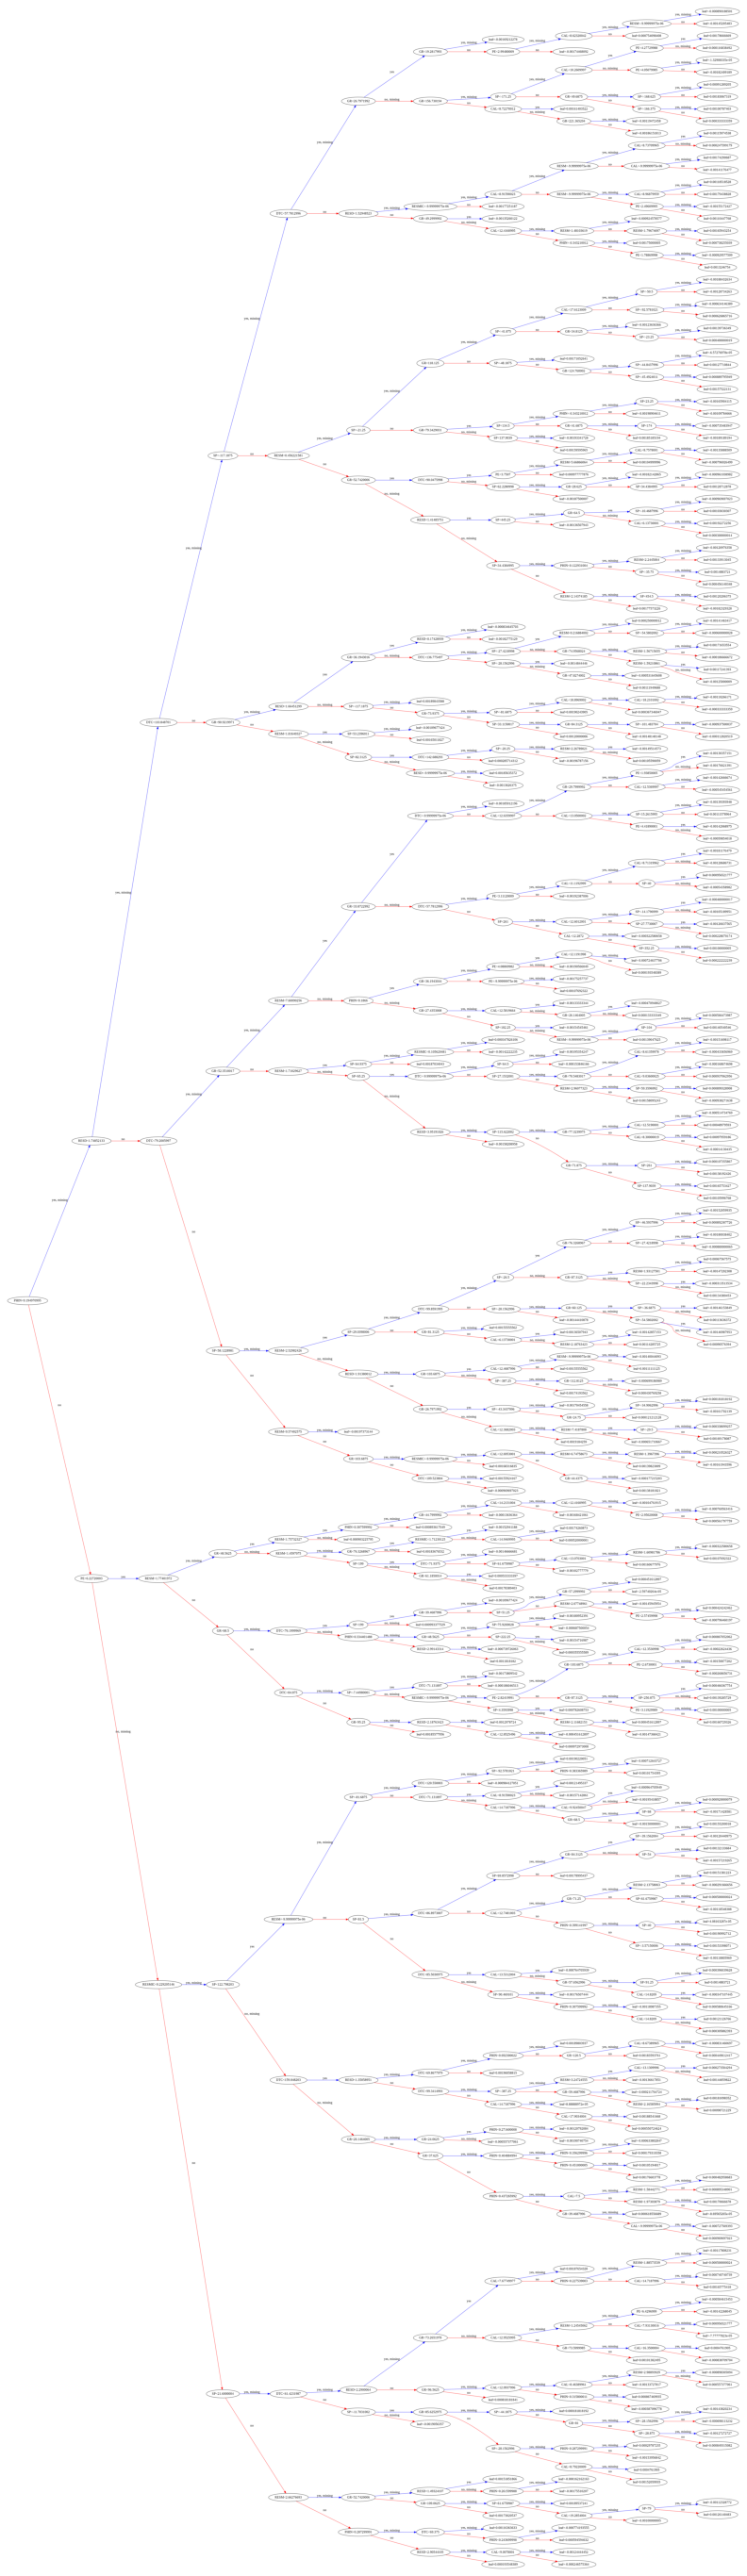

In [0]:
fig, ax = plt.subplots(figsize=(30, 50))
plot_tree(model, rankdir='LR', ax=ax)
plt.show()

In [0]:
plt.savefig("/content/drive/My Drive/datas/tree_temp_10_1_A_10.pdf")

<Figure size 432x288 with 0 Axes>

In [0]:
!pip install shap

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394112 sha256=5f8d3203f210b84fee95ac9dc1ad31ae2381d58665a2c326b4f2a1d986a65907
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [0]:
import shap
import xgboost

In [0]:
model = xgboost.train({'colsample_bylevel':0.5, 'colsample_bytree':0.8, 'gamma':1.0,'learning_rate':0.001, 'max_depth':10, 'min_child_weight':10.0, 'n_estimators':500, 'reg_lambda':5.0, 'silent':False, 'subsample':0.5, 'tree_method':'gpu_hist', 'gpu_id':0}, xgboost.DMatrix(X, label=y), 100)

In [0]:
explainer = shap.TreeExplainer(model)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [0]:
shap_values = explainer.shap_values(X)

In [0]:
shap.summary_plot(shap_values, X)

In [0]:
shap.dependence_plot("GR", shap_values, X)

In [0]:
data_geox_test = data_geox[data_geox['WELL'] == '10/1-A-10']

In [0]:
data_geox_test.head()

In [0]:
X_test = data_geox_test[cols_x]
y_test = data_geox_test['LITHO']

In [0]:
accuracy_score(y_test, model.predict(X_test))

On constate en observant ce puit,que seules les variables **PE, RESS et RESMIC** ne sont renseignées. 

In [0]:
data_geox_test.isna().sum()

In [0]:
data_geox_test.shape

#### Test en retirant un puit mal prédit 11/30a-9Z

In [0]:
data_geox_bad = data_geox[data_geox['WELL'] != '11/30a-9Z']

In [0]:
X = data_geox_bad[cols_x]
y = data_geox_bad['LITHO']

In [0]:
model = XGBClassifier(colsample_bylevel=0.5, colsample_bytree=0.8, gamma=1.0,learning_rate=0.001, max_depth=10, min_child_weight=10.0, n_estimators=500, reg_lambda=5.0, silent=False, subsample=0.5, tree_method='gpu_hist', gpu_id=0)
model.fit(X, y)

In [0]:
fig, ax = plt.subplots(figsize=(30, 50))
plot_tree(model, rankdir='LR', ax=ax)
plt.show()

In [0]:
plt.savefig("/content/drive/My Drive/datas/tree_temp_11_30a_9z.pdf")

In [0]:
data_geox_test = data_geox[data_geox['WELL'] == '11/30a-9Z']

In [0]:
data_geox_test.tail()

In [0]:
data_geox_test.shape

In [0]:
data_geox_test.isna().sum()

In [0]:
X_test = data_geox_test[cols_x]
y_test = data_geox_test['LITHO']

In [0]:
accuracy_score(y_test, model.predict(X_test))


On constate en observant ce puit, que l'on a qu'une seule lithologie. De plus, seules les variables **GR et DTC** sont renseignées.


Les lithologies des puits présentant trop de variables avec des **valeurs NAN** sont mal prédites alors que celles ayant plus de variables différentes de NAN sont globalement bien prédites.

# **13-Automatisation Algorithme de classification**

In [0]:
def tuning_params(X_train, y_train, grille=1):

  xgb = XGBClassifier(tree_method='gpu_hist', gpu_id=0)

  if grille == 1:
    param_grid = {
          'silent': [False],
          'max_depth': [6, 10, 15, 20],
          'learning_rate': [0.001,0.005, 0.01, 0.04, 0.1, 0.2, 0.3, 0.6,1.0],
          'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
          'gamma': [0, 0.25, 0.5, 1.0],
          'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
          'n_estimators': [100,500,1000]}
  else:
     param_grid = {
          'silent': [False],
          'max_depth': [6],
          'learning_rate': [0.001,0.005, 0.01, 0.04, 0.1, 0.2, 0.3, 0.6,1.0],
          'subsample': [1.0],
          'colsample_bytree': [1.0],
          'colsample_bylevel': [1.0],
          'min_child_weight': [1.0],
          'gamma': [0],
          'reg_lambda': [1.0],
          'n_estimators': [100]}


  rs_clf = RandomizedSearchCV(xgb, param_grid, n_iter=30, cv=5, n_jobs=1,
                            scoring='precision', refit=True, random_state=0)
  rs_clf.fit(X_train, y_train)

  resultDf = pd.DataFrame.from_dict(rs_clf.best_params_,orient='index').T

  convert_dict = {'colsample_bylevel': float, 'colsample_bytree':float, 'gamma':float,'learning_rate':float
                , 'max_depth':int, 'min_child_weight':float, 'n_estimators':int, 'reg_lambda':float,
                'silent':bool, 'subsample':float} 

  resultDf = resultDf.astype(convert_dict) 
  return resultDf


In [0]:
def xgboost_class_model(X_train, y_train, X_test, y_test, params):
  model = XGBClassifier(colsample_bylevel=params.loc[0,'colsample_bylevel'], colsample_bytree=params.loc[0,'colsample_bytree'],
                        gamma=params.loc[0,'gamma'], learning_rate=params.loc[0,'learning_rate'],
                        max_depth=params.loc[0,'max_depth'], min_child_weight=params.loc[0,'min_child_weight'],
                        n_estimators=params.loc[0,'n_estimators'], reg_lambda=params.loc[0,'reg_lambda'],
                        silent=params.loc[0,'silent'], subsample=params.loc[0,'subsample'], 
                        tree_method='gpu_hist', gpu_id=0)
  
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  score = accuracy_score(y_test, y_pred)
  precision_argile = precision_score(y_test, y_pred, pos_label=1)
  precision_sable = precision_score(y_test, y_pred, pos_label=0)
  proba = model.predict_proba(X_test)
  return score, precision_argile, precision_sable, proba, model

In [0]:
def model_classification(data_train, data_test, columns, grille=1):
  convert_dict = {'colsample_bylevel': float, 'colsample_bytree':float, 'gamma':float,'learning_rate':float
                , 'max_depth':int, 'min_child_weight':float, 'n_estimators':int, 'reg_lambda':float,
                'silent':bool, 'subsample':float} 

  parameters = pd.DataFrame(columns=['colsample_bylevel','colsample_bytree', 'gamma','learning_rate',
                                     'max_depth', 'min_child_weight', 'n_estimators', 'reg_lambda', 'silent', 'subsample'])
  parameters = parameters.astype(convert_dict) 
  recap = pd.DataFrame(columns=['accuracy', 'precision_argile', 'precision_sable', 'fpr', 'tpr', 'logs'])
  for i in range(len(columns)):
    print("itération: "+str(i))
    X_train = data_train[columns[i].split(',')]
    y_train = data_train['LITHO']
    
    X_test = data_test[columns[i].split(',')]
    y_test = data_test['LITHO']

    print("Tuning des paramètres")
    if grille == 1:
      params = tuning_params(X_train, y_train)
    else:
      params = tuning_params(X_train, y_train, 2)

    print("Apprentissage du modèle")
    score, precision_argile, precision_sable, proba, model = xgboost_class_model(X_train, y_train,X_test, y_test,params)
    fpr, tpr, thresholds = roc_curve(y_test, proba[:,1],pos_label=1)

    recap.loc[i,'accuracy'] = score
    recap.loc[i,'precision_argile'] = precision_argile
    recap.loc[i,'precision_sable'] = precision_sable
    recap.loc[i,'fpr'] = fpr
    recap.loc[i,'tpr'] = tpr
    recap.loc[i,'logs'] = columns[i]

    print("Sauvegarde du modèle")
    print("\n")
    filename = "/content/drive/My Drive/datas/model_"+str(i)+".sav"
    pickle.dump(model, open(filename, 'wb'))
    parameters = pd.concat([parameters, params])

  return parameters, recap

In [0]:
"""
comb = ["GR","GR,DTC", "All-logs", "GR,DTC,RESD,RESM","GR,DTC,RESD,RESM,SP", "GR,DTC,RESS,SP","GR,DTC,SP","GR,PHIN","GR,DTC,PHIN,SP", 
           "GR,DCOR,PHIN","GR,DENS,PHIN", "GR,DTC,PHIN", "GR,DCOR,DENS,PHIN", "GR,DTC,DENS,PHIN", "GR,DCOR,DTC,PHIN",
           "GR,DTC,DCOR,DENS,PHIN"]
comb = ["GR","GR,DTC,DENS,PHIN", "GR,DTC,DCOR,DENS,PHIN", "GR,DTC,RESD,RESM,SP"]"""

'\ncomb = ["GR","GR,DTC", "All-logs", "GR,DTC,RESD,RESM","GR,DTC,RESD,RESM,SP", "GR,DTC,RESS,SP","GR,DTC,SP","GR,PHIN","GR,DTC,PHIN,SP", \n           "GR,DCOR,PHIN","GR,DENS,PHIN", "GR,DTC,PHIN", "GR,DCOR,DENS,PHIN", "GR,DTC,DENS,PHIN", "GR,DCOR,DTC,PHIN",\n           "GR,DTC,DCOR,DENS,PHIN"]\ncomb = ["GR","GR,DTC,DENS,PHIN", "GR,DTC,DCOR,DENS,PHIN", "GR,DTC,RESD,RESM,SP"]'

In [0]:
comb = ["GR", "GR,DTC,DENS,PHIN", "GR,DTC,DCOR,DENS,PHIN", "GR,DTC,RESD,RESM,SP", "GR,DCOR,PHIN"]

In [0]:
#well_test = ['10/1-A-19', '10/1-A-18', '10/1-A-12', '10/1-A-14', '11/30A-A1', '11/30A-A28','13/30-3', '11/30-2','11/30A-A26Z','11/30A-A27']
well_test = [ '11/30A-A1', '11/30A-A28','13/30-3', '11/30-2','11/30A-A26Z','11/30A-A27']
well_others = [ '10/1-A-19', '10/1-A-18', '10/1-A-12', '10/1-A-14','11/30A-A1', '11/30A-A28','13/30-3', '11/30-2','11/30A-A26Z','11/30A-A27']

In [0]:
data_geox_test = data_geox[data_geox['WELL'].isin(well_others)]
data_geox_train = data_geox[data_geox['WELL'].isin(well_others) == False ]

In [0]:
data_geox_test.shape

(47832, 15)

In [0]:
data_geox_train.shape

(414393, 15)

## Tuning de tous les paramètres

In [0]:
parameters, summary = model_classification(data_geox_train, data_geox_test, comb)

itération: 0
Tuning des paramètres
Apprentissage du modèle
Sauvegarde du modèle


itération: 1
Tuning des paramètres
Apprentissage du modèle
Sauvegarde du modèle


itération: 2
Tuning des paramètres
Apprentissage du modèle
Sauvegarde du modèle


itération: 3
Tuning des paramètres
Apprentissage du modèle
Sauvegarde du modèle


itération: 4
Tuning des paramètres
Apprentissage du modèle
Sauvegarde du modèle




In [0]:
parameters

colsample_bylevel  colsample_bytree  gamma  ...  reg_lambda  silent  subsample
0                0.4               0.9   0.50  ...         5.0   False        0.6
0                0.8               0.9   0.25  ...       100.0   False        0.8
0                0.7               0.7   1.00  ...        50.0   False        0.8
0                0.4               0.8   0.00  ...        10.0   False        0.7
0                0.7               0.7   0.00  ...         1.0   False        0.6

[5 rows x 10 columns]

In [0]:
summary

accuracy  ...                   logs
0  0.634157  ...                     GR
1  0.673085  ...       GR,DTC,DENS,PHIN
2  0.647934  ...  GR,DTC,DCOR,DENS,PHIN
3  0.762418  ...    GR,DTC,RESD,RESM,SP
4  0.714062  ...           GR,DCOR,PHIN

[5 rows x 6 columns]

In [0]:
parameters.to_csv("/content/drive/My Drive/datas/parameters.csv")

In [0]:
summary.to_csv("/content/drive/My Drive/datas/summary.csv")

- GridSearch autour des paramètres retenus

In [0]:
col_3 = ['GR', 'DTC', 'RESD', 'RESM', 'SP']
data_geox_test = data_geox[data_geox['WELL'].isin(well_others)]
data_geox_train = data_geox[data_geox['WELL'].isin(well_others) == False ]

In [0]:
X_train = data_geox_train[col_3]
y_train = data_geox_train['LITHO']
X_test = data_geox_test[col_3]
y_test = data_geox_test['LITHO']

In [0]:
X_train_train = pd.concat([X_train, X_train])
y_train_train = pd.concat([y_train, y_train])

In [0]:
xgb = XGBClassifier(tree_method='gpu_hist', gpu_id=0)
param_grid = {
      'silent': [False],
      'max_depth': [14, 15, 16],
      'learning_rate': [0.09,0.001,0.002],
      'subsample': [ 0.7],
      'colsample_bytree': [0.8],
      'colsample_bylevel': [0.4],
      'min_child_weight': [0.5],
      'gamma': [0],
      'reg_lambda':[10],
      'n_estimators': [95,100,105]}

gs_clf = GridSearchCV(xgb, param_grid, cv=5, n_jobs=1,
                          scoring='precision', refit=True)
gs_clf.fit(X_train, y_train)

resultDf = pd.DataFrame.from_dict(gs_clf.best_params_,orient='index').T

In [0]:
convert_dict = {'colsample_bylevel': float, 'colsample_bytree':float, 'gamma':float,'learning_rate':float
                , 'max_depth':int, 'min_child_weight':float, 'n_estimators':int, 'reg_lambda':float,
                'silent':bool, 'subsample':float} 

resultDf = resultDf.astype(convert_dict) 

In [0]:
resultDf.head()

colsample_bylevel  colsample_bytree  gamma  ...  reg_lambda  silent  subsample
0                0.4               0.8    0.0  ...        10.0   False        0.7

[1 rows x 10 columns]

In [0]:
model = XGBClassifier(colsample_bylevel=resultDf.loc[0,'colsample_bylevel'], colsample_bytree=resultDf.loc[0,'colsample_bytree'],
                        gamma=resultDf.loc[0,'gamma'], learning_rate=resultDf.loc[0,'learning_rate'],
                        max_depth=resultDf.loc[0,'max_depth'], min_child_weight=resultDf.loc[0,'min_child_weight'],
                        n_estimators=resultDf.loc[0,'n_estimators'], reg_lambda=resultDf.loc[0,'reg_lambda'],
                        silent=resultDf.loc[0,'silent'], subsample=resultDf.loc[0,'subsample'], 
                        tree_method='gpu_hist', gpu_id=0)

In [0]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.4,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.0, gpu_id=0,
              learning_rate=0.002, max_delta_step=0, max_depth=15,
              min_child_weight=0.5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=10.0, scale_pos_weight=1, seed=None,
              silent=False, subsample=0.7, tree_method='gpu_hist', verbosity=1)

In [0]:
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print('Accuracy : '+str(score))
precision_argile = precision_score(y_test, y_pred, pos_label=1)
print('Précision Argile : '+str(precision_argile))
precision_sable = precision_score(y_test, y_pred, pos_label=0)
print('Précision Sable : '+str(precision_sable))

Accuracy : 0.7649899648770697
Précision Argile : 0.7755285863278657
Précision Sable : 0.7566758919889296


On ne constate pas d'améliorations de nos métriques avec le gridSearch

In [0]:
model_3 = pickle.load(open("/content/drive/My Drive/datas/model_3.sav", 'rb'))

In [0]:
model_3.get_booster().dump_model("/content/drive/My Drive/datas/model_3.json", with_stats=True, dump_format='json')

In [0]:
proba = model_3.predict_proba(X_test)

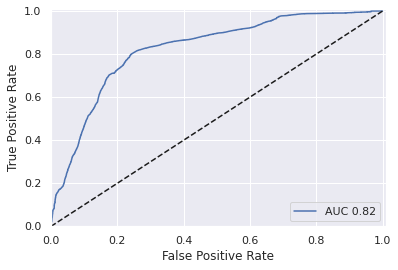

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, proba[:,1],pos_label=1)
auc = auc(fpr,tpr)
roc_courbe(fpr,tpr,auc)

In [0]:
y_pred = model_3.predict(X_test)

In [0]:
df_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=["Sable", "Argile"], index=["Sable", "Argile"])

In [0]:
df_confusion.head()

Sable  Argile
Sable   20203    4764
Argile   6600   16265

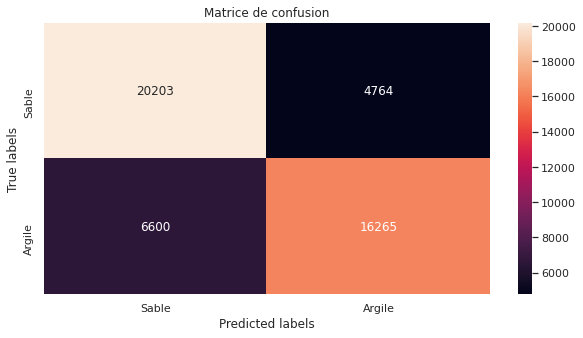

In [0]:
plt.figure(figsize=(10,5))
sns.set() # for label size
sns.heatmap(df_confusion, annot=True, fmt="d")
plt.title('Matrice de confusion')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [0]:
np.array(np.where(y_test == 0)).shape

(1, 24967)

In [0]:
precision_score(y_test, y_pred, pos_label=1)

0.7731902689873418

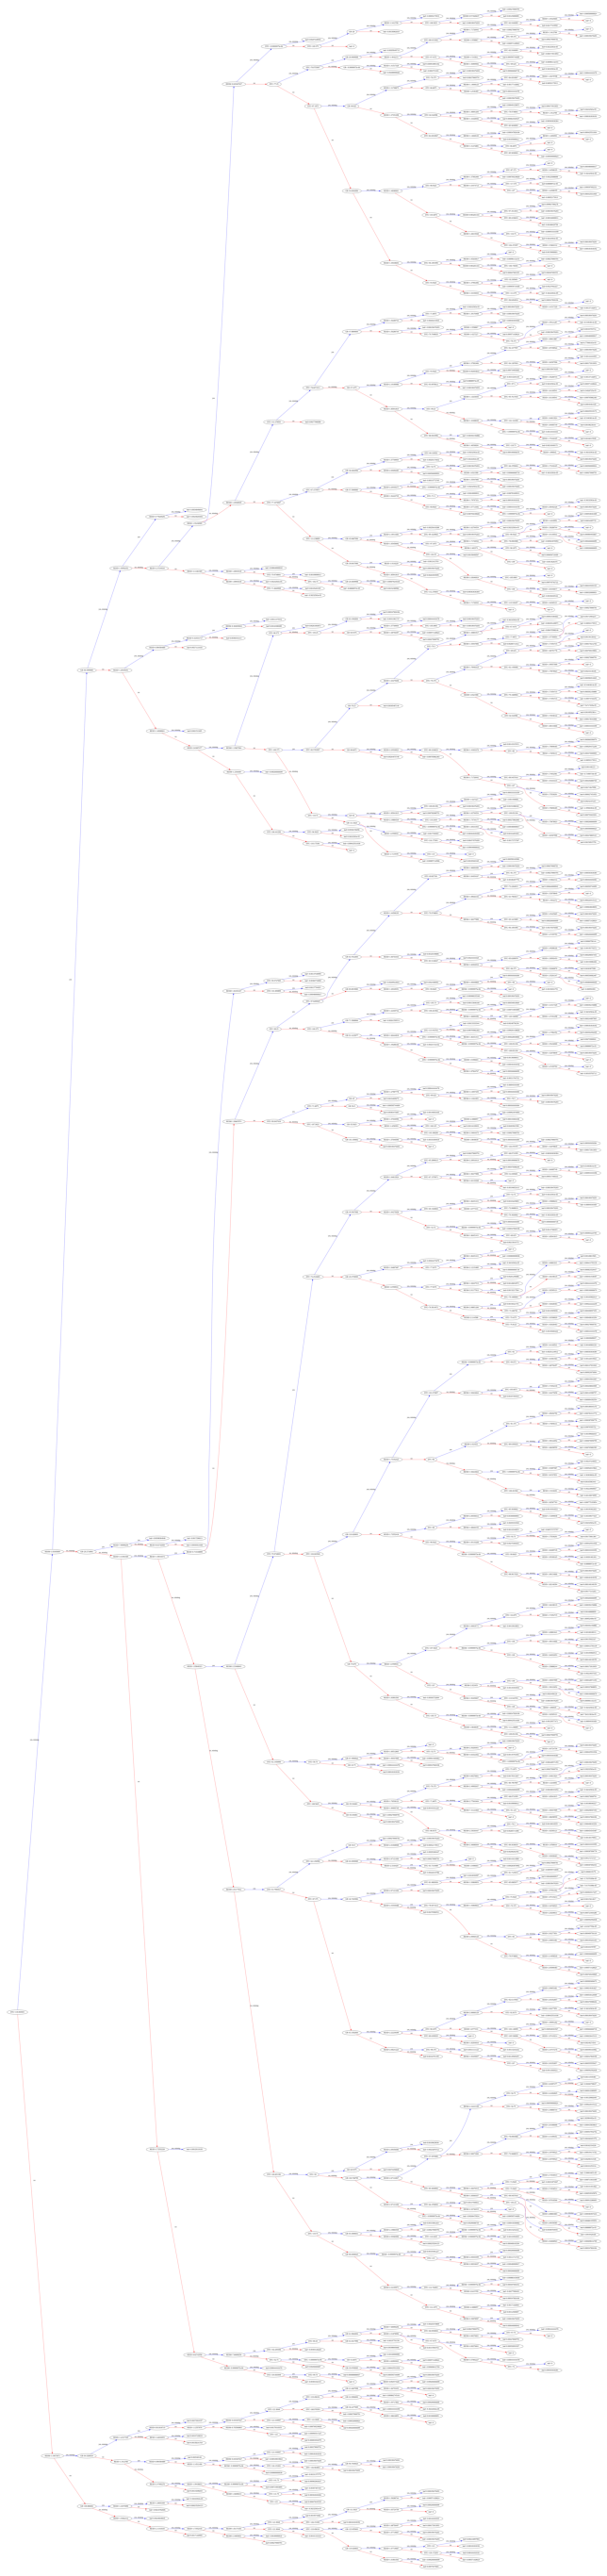

In [0]:
fig, ax = plt.subplots(figsize=(30, 50))
plot_tree(model, num_trees=0, rankdir='LR', ax=ax)
plt.show()

In [0]:
def plot_tree(xgb_model, filename, rankdir='UT'):
    """
    Plot the tree in high resolution
    :param xgb_model: xgboost trained model
    :param filename: the pdf file where this is saved
    :param rankdir: direction of the tree: default Top-Down (UT), accepts:'LR' for left-to-right tree
    :return:
    """
    import xgboost as xgb
    import os
    gvz = xgb.to_graphviz(xgb_model, num_trees=xgb_model.get_booster().best_iteration, rankdir=rankdir)
    _, file_extension = os.path.splitext(filename)
    format = file_extension.strip('.').lower()
    data = gvz.pipe(format=format)
    full_filename = filename
    with open(full_filename, 'wb') as f:
        f.write(data)

In [0]:
filename = "/content/drive/My Drive/datas/xgboost_test_tree_LR.pdf"

In [0]:
plot_tree(model_3, filename, 'LR')

In [0]:
model_3.get_booster().best_iteration

99

In [0]:
xgb = XGBClassifier(tree_method='gpu_hist', gpu_id=0)

In [0]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [0]:
y_pred_lr = xgb.predict(X_test)

In [0]:
precision_score(y_test, y_pred_lr)

0.7577425685701977

In [0]:
from IPython.core.display import display, HTML, Javascript
from string import Template
import json
import IPython.display
%config IPCompleter.greedy=True
%matplotlib inline

In [0]:
def rules(clf, features, labels, node_index=0):
    """Structure of rules in a fit decision tree classifier

    Parameters
    ----------
    clf : DecisionTreeClassifier
        A tree that has already been fit.

    features, labels : lists of str
        The names of the features and labels, respectively.

    """
    node = {}
    if clf.tree_.children_left[node_index] == -1:  # indicates leaf
        #count_labels = zip(clf.tree_.value[node_index, 0], labels)
        #node['name'] = ', '.join(('{} of {}'.format(int(count), label)
        #                          for count, label in count_labels))
        node['type']='leaf'
        node['value'] = clf.tree_.value[node_index, 0].tolist()
        node['error'] = np.float64(clf.tree_.impurity[node_index]).item()
        node['samples'] = clf.tree_.n_node_samples[node_index]
    else:
        feature = features[clf.tree_.feature[node_index]]
        threshold = clf.tree_.threshold[node_index]
        node['type']='split'
        node['label'] = '{} > {}'.format(feature, threshold)
        node['error'] = np.float64(clf.tree_.impurity[node_index]).item()
        node['samples'] = clf.tree_.n_node_samples[node_index]
        node['value'] = clf.tree_.value[node_index, 0].tolist()
        left_index = clf.tree_.children_left[node_index]
        right_index = clf.tree_.children_right[node_index]
        node['children'] = [rules(clf, features, labels, right_index),
                            rules(clf, features, labels, left_index)]
        
    return node

In [0]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [0]:
cols = X_train.columns

In [0]:
d = "/content/drive/My Drive/datas/model_3.json"  
with open(d) as json_file:
    data = json.load(json_file)

In [0]:
html_string = """<!DOCTYPE html>
<html>
  <head>
    <meta http-equiv="Content-Type" content="text/html;charset=utf-8"/>
    <script type="text/javascript" src="https://d3js.org/d3.v3.min.js"></script>
    <style type="text/css">
body {
  font-family: "Helvetica Neue", Helvetica;
}
.hint {
  font-size: 12px;
  color: #999;
}
.node rect {
  cursor: pointer;
  fill: #fff;
  stroke-width: 1.5px;
}
.node text {
  font-size: 11px;
}
path.link {
  fill: none;
  stroke: #ccc;
}
    </style>
  </head>
  <body>
    <div id="body">
      <div id="footer">
        Decision Tree viewer
        <div class="hint">click to expand or collapse</div>
        <div id="menu">
          <select id="datasets"></select>
        </div>

      </div>
    </div>    
"""

In [0]:
js_string="""
 var m = [20, 120, 20, 120],
    w = 1280 - m[1] - m[3],
    h = 800 - m[0] - m[2],
    i = 0,
    rect_width = 80,
    rect_height = 20,
    max_link_width = 20,
    min_link_width = 1.5,
    char_to_pxl = 6,
    root;
// Add datasets dropdown
d3.select("#datasets")
    .on("change", function() {
      if (this.value !== '-') {
        d3.json(this.value, load_dataset);
      }
    })
  .selectAll("option")
    .data([
      "-",
      "/content/drive/My Drive/datas/model_3.json"
    ])
  .enter().append("option")
    .attr("value", String)
    .text(String);
var tree = d3.layout.tree()
    .size([h, w]);
var diagonal = d3.svg.diagonal()
    .projection(function(d) { return [d.x, d.y]; });
var vis = d3.select("#body").append("svg:svg")
    .attr("width", w + m[1] + m[3])
    .attr("height", h + m[0] + m[2] + 1000)
  .append("svg:g")
    .attr("transform", "translate(" + m[3] + "," + m[0] + ")");
// global scale for link width
var link_stoke_scale = d3.scale.linear();
var color_map = d3.scale.category10();
// stroke style of link - either color or function
var stroke_callback = "#ccc";
function load_dataset(json) {
  root = json;
  root.x0 = 0;
  root.y0 = 0;
  var n_samples = root.samples;
  var n_labels = root.value.length;
  if (n_labels >= 2) {
    stroke_callback = mix_colors;
  } else if (n_labels === 1) {
    stroke_callback = mean_interpolation(root);
  }
  link_stoke_scale = d3.scale.linear()
                             .domain([0, n_samples])
                             .range([min_link_width, max_link_width]);
  function toggleAll(d) {
    if (d && d.children) {
      d.children.forEach(toggleAll);
      toggle(d);
    }
  }
  // Initialize the display to show a few nodes.
  root.children.forEach(toggleAll);
  update(root);
}
function update(source) {
  var duration = d3.event && d3.event.altKey ? 5000 : 500;
  // Compute the new tree layout.
  var nodes = tree.nodes(root).reverse();
  // Normalize for fixed-depth.
  nodes.forEach(function(d) { d.y = d.depth * 180; });
  // Update the nodes…
  var node = vis.selectAll("g.node")
      .data(nodes, function(d) { return d.id || (d.id = ++i); });
  // Enter any new nodes at the parent's previous position.
  var nodeEnter = node.enter().append("svg:g")
      .attr("class", "node")
      .attr("transform", function(d) { return "translate(" + source.x0 + "," + source.y0 + ")"; })
      .on("click", function(d) { toggle(d); update(d); });
  nodeEnter.append("svg:rect")
      .attr("x", function(d) {
        var label = node_label(d);
        var text_len = label.length * char_to_pxl;
        var width = d3.max([rect_width, text_len])
        return -width / 2;
      })
      .attr("width", 1e-6)
      .attr("height", 1e-6)
      .attr("rx", function(d) { return d.type === "split" ? 2 : 0;})
      .attr("ry", function(d) { return d.type === "split" ? 2 : 0;})
      .style("stroke", function(d) { return d.type === "split" ? "steelblue" : "olivedrab";})
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });
  nodeEnter.append("svg:text")
      .attr("dy", "12px")
      .attr("text-anchor", "middle")
      .text(node_label)
      .style("fill-opacity", 1e-6);
  // Transition nodes to their new position.
  var nodeUpdate = node.transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + d.x + "," + d.y + ")"; });
  nodeUpdate.select("rect")
      .attr("width", function(d) {
        var label = node_label(d);
        var text_len = label.length * char_to_pxl;
        var width = d3.max([rect_width, text_len])
        return width;
      })
      .attr("height", rect_height)
      .style("fill", function(d) { return d._children ? "lightsteelblue" : "#fff"; });
  nodeUpdate.select("text")
      .style("fill-opacity", 1);
  // Transition exiting nodes to the parent's new position.
  var nodeExit = node.exit().transition()
      .duration(duration)
      .attr("transform", function(d) { return "translate(" + source.x + "," + source.y + ")"; })
      .remove();
  nodeExit.select("rect")
      .attr("width", 1e-6)
      .attr("height", 1e-6);
  nodeExit.select("text")
      .style("fill-opacity", 1e-6);
  // Update the links
  var link = vis.selectAll("path.link")
      .data(tree.links(nodes), function(d) { return d.target.id; });
  // Enter any new links at the parent's previous position.
  link.enter().insert("svg:path", "g")
      .attr("class", "link")
      .attr("d", function(d) {
        var o = {x: source.x0, y: source.y0};
        return diagonal({source: o, target: o});
      })
      .transition()
      .duration(duration)
      .attr("d", diagonal)
      .style("stroke-width", function(d) {return link_stoke_scale(d.target.samples);})
      .style("stroke", stroke_callback);
  // Transition links to their new position.
  link.transition()
      .duration(duration)
      .attr("d", diagonal)
      .style("stroke-width", function(d) {return link_stoke_scale(d.target.samples);})
      .style("stroke", stroke_callback);
  // Transition exiting nodes to the parent's new position.
  link.exit().transition()
      .duration(duration)
      .attr("d", function(d) {
        var o = {x: source.x, y: source.y};
        return diagonal({source: o, target: o});
      })
      .remove();
  // Stash the old positions for transition.
  nodes.forEach(function(d) {
    d.x0 = d.x;
    d.y0 = d.y;
  });
}
// Toggle children.
function toggle(d) {
  if (d.children) {
    d._children = d.children;
    d.children = null;
  } else {
    d.children = d._children;
    d._children = null;
  }
}
// Node labels
function node_label(d) {
  if (d.type === "leaf") {
    // leaf
    var formatter = d3.format(".2f");
    var vals = [];
    d.value.forEach(function(v) {
        vals.push(formatter(v));
    });
    return "[" + vals.join(", ") + "]";
  } else {
    // split node
    return d.label;
  }
}
/**
 * Mixes colors according to the relative frequency of classes.
 */
function mix_colors(d) {
  var value = d.target.value;
  var sum = d3.sum(value);
  var col = d3.rgb(0, 0, 0);
  value.forEach(function(val, i) {
    var label_color = d3.rgb(color_map(i));
    var mix_coef = val / sum;
    col.r += mix_coef * label_color.r;
    col.g += mix_coef * label_color.g;
    col.b += mix_coef * label_color.b;
  });
  return col;
}
/**
 * A linear interpolator for value[0].
 *
 * Useful for link coloring in regression trees.
 */
function mean_interpolation(root) {
  var max = 1e-9,
      min = 1e9;
  function recurse(node) {
    if (node.value[0] > max) {
      max = node.value[0];
    }
    if (node.value[0] < min) {
      min = node.value[0];
    }
    if (node.children) {
      node.children.forEach(recurse);
    }
  }
  recurse(root);
  var scale = d3.scale.linear().domain([min, max])
                               .range(["#2166AC","#B2182B"]);
  function interpolator(d) {
    return scale(d.target.value[0]);
  }
  return interpolator;
}
 """

In [21]:
h = display(HTML(html_string))
data = IPython.display.Javascript(js_string)
IPython.display.display_javascript(data)

In [0]:
!pip install dtreeviz

  Created wheel for dtreeviz: filename=dtreeviz-0.8.2-cp36-none-any.whl size=24505 sha256=49d0fd92895570de4b884dff6e422574782bcebe28ffe375a51895ee2c1772fb
  Stored in directory: /root/.cache/pip/wheels/a2/da/b1/3178bb2b10647b5a6340c1979987e3b0c3b993cb674b0a3dcc
Successfully built dtreeviz


In [0]:
from dtreeviz.trees import *

In [0]:
viz = dtreeviz(model_3, X_train, y_train, cols,target_name='argile')

AttributeError: ignored

## Tuning du learning_rate uniquement

In [0]:
parameters_lr, summary_lr = model_classification(data_geox_train, data_geox_test, comb, 2)

itération: 0
Tuning des paramètres


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=30. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Apprentissage du modèle
Sauvegarde du modèle


itération: 1
Tuning des paramètres


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=30. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Apprentissage du modèle
Sauvegarde du modèle


itération: 2
Tuning des paramètres


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=30. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Apprentissage du modèle
Sauvegarde du modèle


itération: 3
Tuning des paramètres


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=30. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Apprentissage du modèle
Sauvegarde du modèle




In [0]:
parameters_lr

colsample_bylevel  colsample_bytree  gamma  ...  reg_lambda  silent  subsample
0                1.0               1.0    0.0  ...         1.0   False        1.0
0                1.0               1.0    0.0  ...         1.0   False        1.0
0                1.0               1.0    0.0  ...         1.0   False        1.0
0                1.0               1.0    0.0  ...         1.0   False        1.0

[4 rows x 10 columns]

In [0]:
summary_lr

accuracy  ...                   logs
0  0.620672  ...                     GR
1  0.653939  ...       GR,DTC,DENS,PHIN
2  0.647219  ...  GR,DTC,DCOR,DENS,PHIN
3  0.498932  ...    GR,DTC,RESD,RESM,SP

[4 rows x 5 columns]

In [0]:
parameters_lr.to_csv("/content/drive/My Drive/datas/parameters_lr.csv")

In [0]:
summary_lr.to_csv("/content/drive/My Drive/datas/summary_lr.csv")